# Pryngles module: Spangler

This module contains all the physics of light scattered on spangles

In [1]:
from pryngles import *

## External modules

In [2]:
import pandas as pd
import random

#Specialized plotting methods
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from matplotlib.lines import Line2D
from matplotlib.collections import LineCollection
from matplotlib import animation
from celluloid import Camera # getting the camera
from ipywidgets import interact,fixed,widgets

## Aliases

In [3]:
print_df=Misc.print_df
sci=Science

## Constants

In [4]:
"""
    Colors: Given in hue (0-360), level (0: black-1: white), saturation (0-1)
   
    For colors: 
        https://htmlcolorcodes.com/es/
   
    When searching for colors use:
        Misc.rgb_sample(59)
"""
#Type of spangles
SPANGLE_COLORS=dict()
__s=-1

#Spangles for planets with a rocky surface
__s+=1
SPANGLE_SOLID_ROCK=__s
SPANGLE_COLORS[__s]=[27,0.5,1.0]

#Spangles for planets with a rocky surface
__s+=1
SPANGLE_SOLID_ICE=__s
SPANGLE_COLORS[__s]=[27,0.5,1.0]

#Spangles for planets with atmospheres
__s+=1
SPANGLE_ATMOSPHERIC=__s
SPANGLE_COLORS[__s]=[27,0.5,1.0]

#Spangles for planets with liquid surface
__s+=1
SPANGLE_LIQUID=__s
SPANGLE_COLORS[__s]=[195,0.7,0.5]

#Ring or disks spangles
__s+=1
SPANGLE_GRANULAR=__s
SPANGLE_COLORS[__s]=[0,0.7,0.4]

#Gasseous spangle
__s+=1
SPANGLE_GASEOUS=__s
SPANGLE_COLORS[__s]=[27,0.5,1.0]

#Stellar spangle
__s+=1
SPANGLE_STELLAR=__s
SPANGLE_COLORS[__s]=[59,0.7,1.0]

#List of semitransparent spangles
SPANGLES_SEMITRANSPARENT=[SPANGLE_GRANULAR,SPANGLE_GASEOUS]

#Color of shadow
SHADOW_COLOR=[180,0.6,0.0]
SHADOW_COLOR_OBS=[180,0.2,0.0]
SPANGLES_DARKNESS_COLOR=[225,0.3,1]

## The Spangler class

This class contains a family of routines useful for spangling different kind of objects.

In [5]:
Spangler_doc=\
"""A Spangler associated to an object or set of objects.
    
   There are two ways to initialize a Spangler:
    
        Creating a Spangler for a single object:
        
            Mandatory:

                nspangles: int, default = 0:
                    Number of spangles in spangling.

            Optional:

                body_hash: string, default = None:
                    Hash identifying the body to which spangles are associated 
                    (see Body documentation for explanation about hash).

                spangle_type: int, default = 0:
                    Type of spangle (see *_SPANGLE in Consts module).

                n_equ: numpy Array (3), default = [0,0,1]:
                    unitary vector normal to {equ} (equatorial) plane.

                alpha_equ: float, default = 0:
                    Roll angle of x-axis of equatorial system (not implemented yet)

                center_equ: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {equ} (equatorial) system.

                center_ecl: numpy Array (3), default = [0,0,0]:
                    Position of the spnagler in the {ecl} (ecliptic) system.
                    
                w, q0: float [rad/ut, rad], default = 0, 0:
                    Angular velocity and reference latitude at t = 0.

        Joining a set of Spanglers (several objects):

            spanglers: list of Spanglers. default = []:
                Set of spanglers to join.

Core attributes:

    nspangles: int:
        Total number of spangles.

    data: Pandas DataFrame: 
        Dataframe containing all the information about the spangling.
        For Columns see global variable SPANGLER_COLUMNS.
"""

In [212]:
#Columns of spangling
SPANGLER_COLUMNS=odict({
    "sphash":"",

    #Type of spangle
    "spangle_type":SPANGLE_SOLID_ROCK, #For a list of spangle types see the constants module.
    "geometry":SAMPLER_GEOMETRY_CIRCLE, #Geometry of the spangle (see Sampler module constants)

    #Lengh-scale
    "scale":1, #The length scale of the body, eg. for a ring this is the outer radius

    #Body parameters
    "n_equ":[0,0,1], #Direction of the equator of the body with respect
    "alpha_equ":0, #Zero meridian of equatorial system
    "w":0, #Rotational angular velocity [rad/ut]
    "q0":0, #Initial time [rad], Longitude (azimutal angle) are calculated as: q = q0 + w (t - t0)

    #Coordinates of the spangle (cartesian and spherical) in the body-centric system
    "center_equ":[0,0,0],#Center of the body with respect to barycenter
    "x_equ":1,"y_equ":0,"z_equ":0, #Cartesian coordinates
    "r_equ":1,"q_equ":0,"f_equ":0, #Spherical coordinates: q: longitude, f: latitude
    "ns_equ":[0,0,1], #Unitary vector normal to the spangle

    #Coordinates of the spangle (cartesian and spherical) in the ecliptic system
    "center_ecl":[0,0,0],#Center of the body with respect to barycenter
    "x_ecl":1,"y_ecl":0,"z_ecl":0, #Cartesian coordinates of the spangle
    "ns_ecl":[0,0,1],#Unitary vector normal to the spangle, calculated in the class

    #Coordinates of the spangle (cartesian and spherical) in the intersection system
    "center_int":[0,0,0],#Center of the body 
    "x_int":1,"y_int":0,"z_int":0,#Cartesian coordinates
    "ns_int":[0,0,1],#Unitary vector normal to the spangle, calculated in the class
    "rho_int":1,"az_int":0,"cost_int":0, #Pseudo cylindrical coordinates (rho, q, cos(theta))
    "cos_int":1, #Angle between normal to spangle and direction of intersection
    "d_int":1, #Distance of the Spangle to intersection
    "z_cen_int":0, #z-coordiante of the center

    #Coordinates of the spangle (cartesian and spherical) in the observer system
    "center_obs":[0,0,0], #Center of the body
    "x_obs":1,"y_obs":0,"z_obs":0, #Cartesian coordinates of the spangle
    "ns_obs":[0,0,1],#Unitary vector normal to the spangle, calculated in the class
    "rho_obs":1,"az_obs":0,"cost_obs":0, #Cylindrical coordinates of the spangle: rho, q, cos(theta)
    "cos_obs":1, #Angle between normal to spangle and direction of observer
    "d_obs":1, #Distance of the Spangle to light-source
    "z_cen_obs":0, #z-coordiante of the center
    
    #Coordinates of the spangle (cartesian and spherical) in the light-source system
    "center_luz":[0,0,0],#Center of the body
    "x_luz":1,"y_luz":0,"z_luz":0,#Calculated in the class
    "ns_luz":[0,0,1],#Unitary vector normal to the spangle, calculated in the class
    "rho_luz":1,"az_luz":0,"cost_luz":0, #Cylindrical coordinates of the spangle: rho, q, cos(theta)
    "cos_luz":1, #Angle between normal to spangle and direction of light-source
    "d_luz":1, #Distance of the Spangle to light-source
    "z_cen_luz":0, #z-coordiante of the center

    #Geometrical parameters
    "asp":1.0, #Effective area of the spangle
    "dsp":1.0, #Effective diameter of spangle, dsp = 2*(asp/pi)**0.5

    #Optical parameters
    "albedo_gray_normal":1.0,
    "tau_gray_optical":0.0,
    
    #Special states
    "unset":True, #State has not been set
    "hidden":False, #The spangle is not taken into account for photometry
    "source":False, #The spangle belongs to a light-source (it does not reflect light)
})

SPANGLER_VISIBILITY_STATES=odict({
    #Spangle state
    "visible":False, #The spangle is visible from observer
    "intersect":False, #Intermediate state to calculate intersections
    "shadow":False, #The spangle is in the shadow of other spangler
    "indirect":False, #The spangle is indirectly illuminated
    "emit":False, #The spangle is emmitting
    "above":False, #Intermediate state to calculate above or below state respect to ring
})
SPANGLER_COLUMNS.update(SPANGLER_VISIBILITY_STATES)

SPANGLER_SOURCE_STATES=odict({
    "illuminated":False, #The spangle is illuminated by the light-source
    "transmit":False, #The spangle is illuminated but transmitting light
    "transit":False, #The spangle is transiting
    "occult":False, #The spangle is occulted by a light source
})
SPANGLER_COLUMNS.update(SPANGLER_SOURCE_STATES)

#States corresponging to a given point of view
SPANGLER_EQUIV_COL=dict(obs="visible",int="intersect",luz="illuminated")

#Columns to copy when calculating visibility and illumination
SPANGLER_COL_COPY=["center","x","y","z","ns","rho","az","cost","cos","d","z_cen"]
SPANGLER_COL_LUZ=[column+"_luz" for column in SPANGLER_COL_COPY]
SPANGLER_COL_OBS=[column+"_obs" for column in SPANGLER_COL_COPY]
SPANGLER_COL_INT=[column+"_int" for column in SPANGLER_COL_COPY]

#Spangler columns wich correspond to lengths
SPANGLER_LENGTHS=[
    "x_equ","y_equ","z_equ",
    "x_ecl","y_ecl","z_ecl",
    "x_obs","y_obs","z_obs","d_obs",
    "x_luz","y_luz","z_luz","d_luz",
    "r_equ","rho_obs","rho_luz",
    "dsp"
]

#Spangler columns which correspond to areas
SPANGLER_AREAS=[
    "asp",
]
#Spangler columns which correspond to vectores
SPANGLER_VECTORS=[
    "center_ecl",
    "center_equ",
    "center_obs",
    "center_int",
]

SPANGLER_KEY_FIELDS=["sphash","spangle_type","geometry",
                     "x_obs","y_obs","z_obs","d_obs","cos_obs",
                     "x_luz","y_luz","z_luz","d_luz","cos_luz",
                     "x_int","y_int","z_int"]+\
                     ["unset"]+\
                     list(SPANGLER_VISIBILITY_STATES)+list(SPANGLER_SOURCE_STATES)

#Tolerance in area of the inner border
SPANGLER_EPS_BORDER=0.05

In [213]:
class Spangler(PrynglesCommon):
    
    def __init__(self,
                 #Initialization using specific options
                 #Initialization with a list of spanglers
                     spanglers=[],
                 #Basic
                     nspangles=1,
                     sphash=None,
                     n_equ=SPANGLER_COLUMNS["n_equ"],
                     alpha_equ=SPANGLER_COLUMNS["alpha_equ"],
                     center_equ=SPANGLER_COLUMNS["center_equ"],
                     center_ecl=SPANGLER_COLUMNS["center_ecl"],
                 #Optional
                     w=SPANGLER_COLUMNS["w"],
                     q0=SPANGLER_COLUMNS["q0"],
                ):
        
        #Common attributes
        self.n_obs=np.array([0,0,1])
        self.n_luz=np.array([0,0,1])
        self.n_int=np.array([0,0,1])
        self.d_int=self.d_obs=self.d_luz=1
        self.sample=None
        self.geometry=-1
        
        #Direction of vantages point in spherical coordinates
        self.rqf_obs=sci.spherical(self.n_obs)
        self.rqf_luz=sci.spherical(self.n_luz)
        self.rqf_int=sci.spherical(self.n_int)
        self.center_luz=None
        self.center_obs=None
        
        #Transformation matrices from equatorial to ecliptic coordinates
        self.M_equ2ecl=dict()
        self.M_ecl2equ=dict()
        
        #Convex hulls of spanglers
        self.qhulls=dict()
        
        #Create a spanglers with a list of other spanglers
        if len(spanglers)>0:
            verbose(VERB_SIMPLE,f"Joining {len(spanglers)} spanglers")
            self._join_spanglers(spanglers)
            
        #Create a spangler with the desired options
        else:
            #Attributes
            self.nspangles=nspangles
            self.shape="vanilla" #No geometry defined
            
            #Default property values
            self._defaults=deepcopy(SPANGLER_COLUMNS)

            if not sphash:
                #Generate a random hash for object
                self.sphash=str(random.getrandbits(16))
                verbose(VERB_VERIFY,f"Generating random hash {self.sphash}")
            else:
                self.sphash=sphash
                
            self._defaults.update(dict(sphash=self.sphash))
            
            #Update other parameters
            self._defaults.update(
                dict(w=w,q0=q0)
            )

            #Create Spangler dataframe
            if self.nspangles>0:
                
                #Create a simple DataFrame with the default values
                self.data=pd.DataFrame([list(self._defaults.values())]*self.nspangles,
                                       columns=self._defaults.keys())

                #Update positions
                self.set_positions(
                    n_equ=n_equ,alpha_equ=alpha_equ,
                    center_equ=center_equ,center_ecl=center_ecl,
                    t=None
                )
        
            else:        
                verbose(VERB_SIMPLE,f"Creating a blank Spangler")
                #Creat a blank DataFrame
                self.data=pd.DataFrame(columns=self._defaults.keys())
        
    def reset_state(self):
        """Reset spangler state
        """
        self.data[list(SPANGLER_SOURCE_STATES)+list(SPANGLER_VISIBILITY_STATES)]=False
        self.data["unset"]=True

    def set_scale(self,scale):
        """Set scale
        
        scale: float:
            New scale.  All lengths will be multiplied by scale, areas by scale**2 and
            vector components by scale.
        """
        self.scale=scale
        self.data[SPANGLER_LENGTHS]*=self.scale
        self.data[SPANGLER_AREAS]*=self.scale**2
        for vector in SPANGLER_VECTORS:
            self.data[vector]=[np.array(v)*scale for v in self.data[vector]]
        
    def _join_spanglers(self,spanglers):
        """
        Join spanglers into a single spangler

        Parameters:
            spanglers: list of Spanglers:
                Spanglers to join.
        """
        self.sphash=[]
        for spangler in spanglers:
            if not isinstance(spangler,Spangler):
                raise AssertionError(f"One of the spangler is not an Spangler instance")
                
            if spangler.sphash in self.sphash:
                raise ValueError(f"Hash '{spangler.sphash}' already included in spangler '{self.sphash}'")
                
            self.sphash+=[spangler.sphash]

        #When joining there is no single geometry
        self.shape="Join"
        
        #Set of spanglers
        self.spanglers=spanglers

        #Concatenate data
        datas=[spangler.data for spangler in spanglers]
        self.data=pd.concat(datas,ignore_index=True)

        self.M_equ2ecl=dict()
        for spangler in spanglers:
            self.M_equ2ecl.update(spangler.M_equ2ecl)

        #Join properties
        self.nspangles=len(self.data)
        

    def set_positions(self,
                      n_equ=[],alpha_equ=0,
                      center_equ=[],center_ecl=[],
                      t=None
                     ):
        """
        Set the positions and orientation of spanglers in all reference systems.

        Parameters:

            n_equ: list/array (3), default = []:
                Normal vector towards north pole equatorial system.

            alpha_equ: float, default = 0:
                Roll angle of x-axis of equatorial system (not implemented yet)

            center_equ: list/array (3), default = []:
                Location of the center of the body with respect to the barycenter in the equatorial system.

            center_ecl: list/array (3), default = []:
                Location of the center of the body with respect to the barycenter in the ecliptic system.

            t: float, default = None:
                Time.  This quantity is used to update the equatorial coordinates.
                If None, equatorial coordinates are not set.

        Return:
            None

        Update:
    
            If n_equ:
                Rotation matrices M_equ2ecl

            If t is provided:
                Coordinates of the spangles in the equatorial, (x_equ,y_equ,z_equ).
                Normals to the spangle (ns_equ)

            In all cases:
                Coordinates of the spangles, (x_ecl,y_ecl,z_ecl).
            
        """
        verbose(VERB_VERIFY,f"Setting positions")

        #Update normal vectors
        qupdate=False

        #Update center
        if len(center_equ)>0:
            verbose(VERB_VERIFY,f"Updating center in {{equ}} to {center_equ}")
            self.data["center_equ"]=[center_equ]*self.nspangles
            
        if len(center_ecl)>0:
            verbose(VERB_VERIFY,f"Updating center {{ecl}} to {center_ecl}")
            self.data["center_ecl"]=[center_ecl]*self.nspangles

        if len(n_equ)>0:
            verbose(VERB_VERIFY,f"Generating equatorial transformation matrices from n_equ = {n_equ}")

            #Unitary equatorial vector
            n_equ,one=spy.unorm(n_equ)
            self.data["n_equ"]=[n_equ]*self.nspangles

            #Transformation matrices
            self.M_equ2ecl[self.sphash],M_ecl2equ=sci.rotation_matrix(n_equ,alpha_equ)

            qupdate=True

        #Update equatorial coordinates by rotation
        if t is not None:
            verbose(VERB_VERIFY,f"Updating rotations at t = {t}")

            self.data["q_equ"]=[q+q0+w*t for q,w,q0 in zip(self.data.q_equ,self.data.w,self.data.q0)]
            self.data[["x_equ","y_equ","z_equ"]]=\
                [sci.cartesian(r) for r in np.array(self.data[["r_equ","q_equ","f_equ"]])]

            qupdate=True

        #If equatorial positions have been changed
        if qupdate and self.sample:
 
            #Update spangles orientations
            verbose(VERB_VERIFY,f"Generating normal vectors")

            #If the spangler has been poputaled update normals
            if self.sample:
                self.data["ns_equ"]=pd.Series(
                    list(
                        self.sample.update_normals(self.data[["x_equ","y_equ","z_equ"]])
                    ),dtype=object
                )

        #Convert from equatorial to ecliptic
        verbose(VERB_VERIFY,f"Converting to equatorial")
        self.data[["x_ecl","y_ecl","z_ecl"]]=\
            [np.matmul(self.M_equ2ecl[sph],r+cequ)+cecl\
             for sph,r,cequ,cecl in zip(self.data.sphash,
                                        np.array(self.data[["x_equ","y_equ","z_equ"]]),
                                        self.data.center_equ,self.data.center_ecl)]
        self.data["ns_ecl"]=[np.matmul(self.M_equ2ecl[sph],n) for sph,n in zip(self.data.sphash,
                                                                               self.data.ns_equ)]

        #Update velocities
        #Not implemented yet
    
Spangler.__doc__=Spangler_doc

### Test class

In [214]:
if IN_JUPYTER:
    def test_init(self):
        
        Verbose.VERBOSITY=VERB_ALL
        
        print("Basic definition:")
        sg=Spangler(nspangles=1,center_equ=[0,0,0],n_equ=[1,0,0])
        Misc.print_df(sg.data.head(1))

        print("\nCenter equ:")
        sg=Spangler(nspangles=3,center_equ=[0,0,1])
        Misc.print_df(sg.data.head(1))

        print("\nCenter ecl:")
        sg=Spangler(nspangles=3,center_ecl=[0,0,1])
        Misc.print_df(sg.data.head(1))

        print("\nRotation:")
        sg=Spangler(nspangles=3,w=30*Consts.deg,q0=40*Consts.deg)
        sg.set_positions(t=1)
        Misc.print_df(sg.data.head(1))

        print("\nJoin:")
        sg1=Spangler(sphash="Body 1",nspangles=3,w=40*Consts.deg)
        sg2=Spangler(sphash="Body 2",nspangles=3,w=30*Consts.deg)
        sg=Spangler(spanglers=[sg1,sg2])
        sg.set_positions(t=1)
        Misc.print_df(sg.data)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_init=test_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

Basic definition:
      VERB3::__init__:: Generating random hash 2382
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 0]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
      VERB3::set_positions:: Converting to equatorial


,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,2382,0,0,1,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",0.0,1.0,0.0,"[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False



Center equ:
      VERB3::__init__:: Generating random hash 61104
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 1]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial


,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,61104,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 1]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 0]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False



Center ecl:
      VERB3::__init__:: Generating random hash 43119
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 1]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial


,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,43119,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",1,0,0,1,0,0,"[0, 0, 1]","[0, 0, 1]",1.0,0.0,1.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False



Rotation:
      VERB3::__init__:: Generating random hash 20196
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating rotations at t = 1
      VERB3::set_positions:: Converting to equatorial


,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,20196,0,0,1,"[0.0, 0.0, 1.0]",0,0.523599,0.698132,"[0, 0, 0]",0.34202,0.939693,0.0,1,1.22173,0,"[0, 0, 1]","[0, 0, 0]",0.34202,0.939693,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False



Join:
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial
  VERB1::__init__:: Joining 2 spanglers
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating rotations at t = 1
      VERB3::set_positions:: Converti

,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,Body 1,0,0,1,"[0.0, 0.0, 1.0]",0,0.698132,0,"[0, 0, 0]",0.766044,0.642788,0.0,1,0.698132,0,"[0, 0, 1]","[0, 0, 0]",0.766044,0.642788,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
1,Body 1,0,0,1,"[0.0, 0.0, 1.0]",0,0.698132,0,"[0, 0, 0]",0.766044,0.642788,0.0,1,0.698132,0,"[0, 0, 1]","[0, 0, 0]",0.766044,0.642788,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
2,Body 1,0,0,1,"[0.0, 0.0, 1.0]",0,0.698132,0,"[0, 0, 0]",0.766044,0.642788,0.0,1,0.698132,0,"[0, 0, 1]","[0, 0, 0]",0.766044,0.642788,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
3,Body 2,0,0,1,"[0.0, 0.0, 1.0]",0,0.523599,0,"[0, 0, 0]",0.866025,0.500000,0.0,1,0.523599,0,"[0, 0, 1]","[0, 0, 0]",0.866025,0.500000,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
4,Body 2,0,0,1,"[0.0, 0.0, 1.0]",0,0.523599,0,"[0, 0, 0]",0.866025,0.500000,0.0,1,0.523599,0,"[0, 0, 1]","[0, 0, 0]",0.866025,0.500000,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
5,Body 2,0,0,1,"[0.0, 0.0, 1.0]",0,0.523599,0,"[0, 0, 0]",0.866025,0.500000,0.0,1,0.523599,0,"[0, 0, 1]","[0, 0, 0]",0.866025,0.500000,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.534s

OK


In [215]:
if IN_JUPYTER:
    def test_reset(self):

        Verbose.VERBOSITY=VERB_SIMPLE

        sg=Spangler(nspangles=100)
        sg.reset_state()
        print_df(sg.data[["unset"]+list(SPANGLER_VISIBILITY_STATES)+list(SPANGLER_SOURCE_STATES)].head())

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_reset=test_reset
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

,unset,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,True,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.013s

OK


In [216]:
if IN_JUPYTER:
    def test_scale(self):

        Verbose.VERBOSITY=VERB_SIMPLE

        sg=Spangler(center_ecl=[1,1,1],center_equ=[1,1,1])
        print_df(sg.data)

        sg.set_scale(5)
        print_df(sg.data)

        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_scale=test_scale
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,23197,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[1, 1, 1]",1,0,0,1,0,0,"[0, 0, 1]","[1, 1, 1]",3.0,2.0,2.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.0,1.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False


,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,23197,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[5, 5, 5]",5,0,0,5,0,0,"[0, 0, 1]","[5, 5, 5]",15.0,10.0,10.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",5,0,0,"[0, 0, 1]",5,0,0,1,5,0,"[0, 0, 0]",5,0,0,"[0, 0, 1]",5,0,0,1,5,0,25.0,5.0,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.035s

OK


### Populate Spangler

In [217]:
def populate_spangler(self,
                      shape="circle",preset=False,spangle_type=SPANGLE_SOLID_ROCK,
                      scale=1,seed=0,**shape_args):
    
    """Populate data of a Spangler using points generated with a given geometry.
    
    Parameters:
            
        shape: string, default = "circle":
            Shape of the Sampler.  Available: "circle", "ring", "sphere".

        spangle_type: int, default = SPANGLE_SOLID_ROCK:
            Type of spangle.  See Constants module for a list of spangle types.

        preset: boolean, default = False:
            If true the spangler is populated with preset data (see class Sampler for details).
            
        scale: float. default = 1:
            Scale size of the object.
            
        seed: integer. default = 0:
            Value of the integer seed of random number generation (if 0 no random seed is set).
            If a non-zero seed is used the position of the spangle will be always the same.
            
        shape_args: dictionary:
            See Sampler methods documentation.
             
    """
    #Check if preset
    if preset:
        verbose(VERB_VERIFY,f"Populating spangler from preset for {shape}")
        preset=(shape,shape_args)
        self.sample=Sampler(preset=preset,N=self.nspangles,seed=seed)   
    else:
        verbose(VERB_VERIFY,f"Generating spangler from scratch")
        self.sample=Sampler(N=self.nspangles,seed=seed)
        exec(f"self.sample.gen_{shape}(**shape_args)")

    self.shape=shape
    self.data["geometry"]=self.sample.geometry
    self.data["spangle_type"]=spangle_type

    if self.sample.geometry in [SAMPLER_GEOMETRY_SPHERE]:
        #Purge sample if it is in 3d
        verbose(VERB_VERIFY,f"Purging 3d sample")
        self.sample.purge_sample()
        self.nhidden=0
        
    elif self.shape == "ring":
        #Number of hidden points
        """
        The number of hidden points for a ring is choosen in such a way that the ratio between t
        he area of the circle sector to the area of the circle segment is larger than (1-epsilon)
        
        Ag / As = (r^2 sin(teta)/2)/(r^2 teta/2) > (1-epsilon)
        
        Expanding sin(teta) we get:
        
        1 - teta^2/6 > 1 - epsilon
        """
        nhidden=int(2*np.pi/(6*SPANGLER_EPS_BORDER)**0.5)

        #Add hidden spangles to ring inner borders
        pp_border=np.zeros((nhidden,3))
        ss_border=np.zeros((nhidden,3))
        ns_border=np.zeros((nhidden,3))
        for i,theta in enumerate(np.linspace(0,2*np.pi,nhidden)):
            pp_border[i]=[self.sample.ri,theta,0]
            ss_border[i]=[self.sample.ri*np.cos(theta),
                          self.sample.ri*np.sin(theta),
                          0]
            ns_border[i]=[0,0,1]
        self.sample.pp=np.vstack((self.sample.pp,pp_border))
        self.sample.ss=np.vstack((self.sample.ss,ss_border))
        self.sample.ns=np.vstack((self.sample.ns,ns_border))
        self.sample.N+=nhidden
        self.nhidden=nhidden
                
    #Check if number of samples is not equal to that of spangles defined when the spangler was created
    if self.sample.N!=self.nspangles:
        verbose(VERB_SYSTEM,f"Sample size {self.sample.N} is different from spangles {self.nspangles}. Adjusting.")

        #Difference between sampler number of points and number of spanglers
        dif=self.sample.N-self.nspangles
        
        if dif>0:
            #Add spangles
            verbose(VERB_SYSTEM,f"Adding {dif} entries to DataFrame")
            for i in range(dif):
                df=pd.DataFrame([self.data.iloc[-1]])
                self.data=pd.concat([self.data,df],ignore_index=True)
        else:
            #Remove spangles
            verbose(VERB_SYSTEM,f"Removing {-dif} entries to DataFrame")
            self.data.drop(range(self.nspangles+dif,self.nspangles),inplace=True)
            
        self.nspangles=self.sample.N
    
    #Area
    self.data["asp"]=self.sample.aes*scale**2
    self.data["dsp"]=2*(self.data["asp"]/np.pi)**0.5
    
    #Update scale
    self.data["scale"]=scale

    #Store positions in DataFrame
    self.data[["x_equ","y_equ","z_equ"]]=self.sample.ss*scale
    self.data[["r_equ","q_equ","f_equ"]]=self.sample.pp
    self.data["r_equ"]*=scale

    #Update normal vectors
    self.data["ns_equ"]=pd.Series(list(self.sample.ns),dtype=object)
        
    #Hide border points in case of ring
    if shape == "ring":
        self.data.loc[self.nspangles-self.nhidden:self.nspangles,"hidden"]=True
        
    #Update positions
    self.set_positions()
    
Spangler.populate_spangler=populate_spangler

      VERB3::__init__:: Generating random hash 28944
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [1, 0, 0]
      VERB3::rotation_matrix:: Rotation axis: [0. 1. 0.] [0. 0. 1.] [1. 0. 0.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::populate_spangler:: Generating spangler from scratch
    VERB2::populate_spangler:: Sample size 862 is different from spangles 850. Adjusting.
    VERB2::populate_spangler:: Adding 12 entries to DataFrame
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Converting to equatorial


<IPython.core.display.Javascript object>


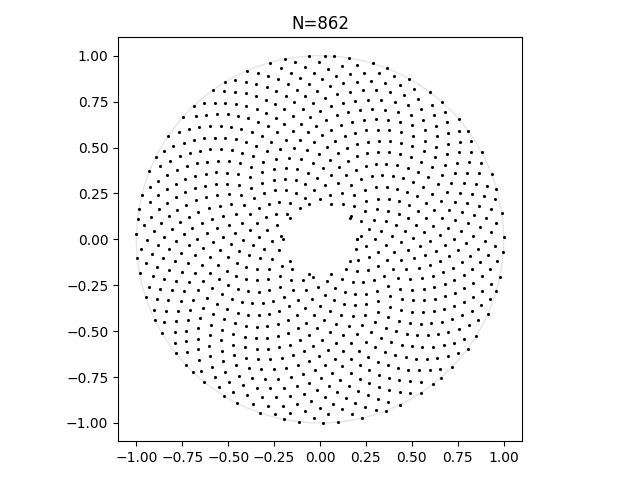

,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,28944,4,0,2,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",0.387129,-0.107400,0.0,0.401751,6.012565,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",0.0,0.387129,-0.107400,"[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,0.014176,0.134348,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
1,28944,4,0,2,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",-0.215973,0.345597,0.0,0.407531,2.129343,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",0.0,-0.215973,0.345597,"[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,0.014176,0.134348,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
2,28944,4,0,2,"[1.0, 0.0, 0.0]",0,0,0,"[0, 0, 0]",-0.075234,-0.406325,0.0,0.413231,4.529306,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",0.0,-0.075234,-0.406325,"[1.0, 0.0, 0.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,0.014176,0.134348,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False


      VERB3::__init__:: Generating random hash 1709
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::populate_spangler:: Populating spangler from preset for ring
  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})
      VERB3::__init__:: Original ring preset 850
      VERB3::__init__:: Computed ring preset 885
    VERB2::__init__:: Reading preset data from /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/src/pryngles/data/sampler_presets/sample_circle_N_900.pkl
    VERB2::load_from:: Loading object from /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProce

<IPython.core.display.Javascript object>


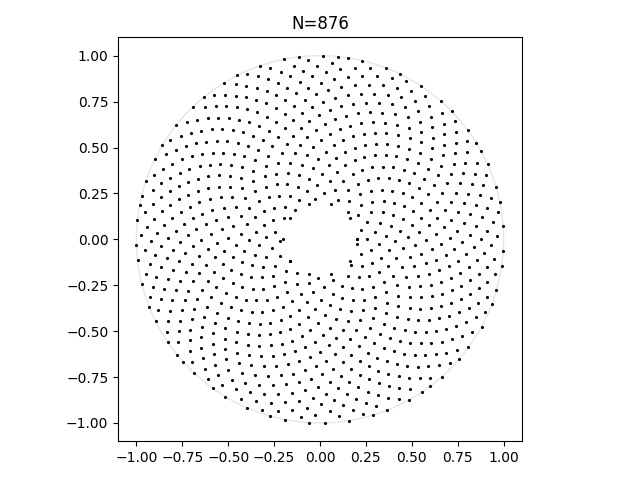

,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,1709,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.165299,-0.116207,0.0,0.202060,3.754336,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",-0.165299,-0.116207,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,0.003487,0.066628,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
1,1709,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",0.203186,-0.026334,0.0,0.204886,6.154300,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",0.203186,-0.026334,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,0.003487,0.066628,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
2,1709,0,0,1,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.133832,0.158800,0.0,0.207673,2.271078,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",-0.133832,0.158800,0.0,"[0.0, 0.0, 1.0]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,0.003487,0.066628,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False


      VERB3::__init__:: Generating random hash 35614
      VERB3::set_positions:: Setting positions
      VERB3::set_positions:: Updating center in {equ} to [0, 0, 0]
      VERB3::set_positions:: Updating center {ecl} to [0, 0, 0]
      VERB3::set_positions:: Generating equatorial transformation matrices from n_equ = [0, 0, 1]
      VERB3::rotation_matrix:: Rotation axis: [1 0 0] [0. 1. 0.] [0. 0. 1.]
      VERB3::set_positions:: Converting to equatorial
      VERB3::populate_spangler:: Populating spangler from preset for sphere
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
    VERB2::__init__:: Reading preset data from /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/src/pryngles/data/sampler_presets/sample_sphere_N_100.pkl
    VERB2::load_from:: Loading object from /Users/jorgezuluagacallejas/Dropbox/MiInvestigacion/PapersEnProceso/Exorings/pryngles/src/pryngles/data/sampler_presets/sample_sphere_N_100.pkl
      VERB3::load_from:

<IPython.core.display.Javascript object>


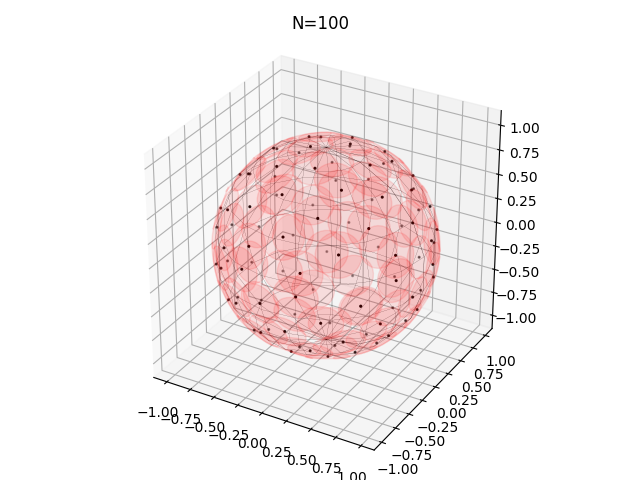

,sphash,spangle_type,geometry,scale,n_equ,alpha_equ,w,q0,center_equ,x_equ,y_equ,z_equ,r_equ,q_equ,f_equ,ns_equ,center_ecl,x_ecl,y_ecl,z_ecl,ns_ecl,center_int,x_int,y_int,z_int,ns_int,rho_int,az_int,cost_int,cos_int,d_int,z_cen_int,center_obs,x_obs,y_obs,z_obs,ns_obs,rho_obs,az_obs,cost_obs,cos_obs,d_obs,z_cen_obs,center_luz,x_luz,y_luz,z_luz,ns_luz,rho_luz,az_luz,cost_luz,cos_luz,d_luz,z_cen_luz,asp,dsp,albedo_gray_normal,tau_gray_optical,unset,hidden,source,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,35614,0,1,3,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",0.381582,-0.183017,-2.97,3.0,5.835968,-1.429257,"[0.12719395512303389, -0.06100571924139298, -0.99]","[0, 0, 0]",0.381582,-0.183017,-2.97,"[0.12719395512303389, -0.06100571924139298, -0.99]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.130973,1.2,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
1,35614,0,1,3,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.271838,0.676760,-2.91,3.0,1.952746,-1.325231,"[-0.09061259123825989, 0.22558669798790898, -0.97]","[0, 0, 0]",-0.271838,0.676760,-2.91,"[-0.09061259123825989, 0.22558669798790898, -0.97]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.130973,1.2,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False
2,35614,0,1,3,"[0.0, 0.0, 1.0]",0,0,0,"[0, 0, 0]",-0.329712,-0.876807,-2.85,3.0,4.352709,-1.253236,"[-0.10990398845091583, -0.2922689058428573, -0.95]","[0, 0, 0]",-0.329712,-0.876807,-2.85,"[-0.10990398845091583, -0.2922689058428573, -0.95]","[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,"[0, 0, 0]",1,0,0,"[0, 0, 1]",1,0,0,1,1,0,1.130973,1.2,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False


.
----------------------------------------------------------------------
Ran 1 test in 0.933s

OK


In [218]:
if IN_JUPYTER:
    def test_pop(self):
        Verbose.VERBOSITY=VERB_ALL

        #No preset
        sg=Spangler(nspangles=850,n_equ=[1,0,0])
        sg.populate_spangler(shape="ring",
                             spangle_type=GASEOUS_SPANGLE,
                             scale=2,seed=1,ri=0.2)
        sg.sample.plot()
        sg.sample.ax.set_title(f"N={sg.nspangles}")
        sg.sample.fig.tight_layout()
        print_df(sg.data.head(3))

        #Using preset
        sg=Spangler(nspangles=850)
        sg.populate_spangler(shape="ring",
                             preset=True,
                             spangle_type=SOLID_SPANGLE,ri=0.2)
        sg.sample.plot()
        sg.sample.ax.set_title(f"N={sg.nspangles}")
        sg.sample.fig.tight_layout()
        print_df(sg.data.head(3))
    
        #Sphere
        sg=Spangler(nspangles=100)
        sg.populate_spangler(shape="sphere",scale=3,seed=1,preset=True)
        sg.sample.plot(spangled=dict(color='r',alpha=0.1))
        sg.sample.ax.set_title(f"N={sg.nspangles}")
        sg.sample.fig.tight_layout()
        print_df(sg.data.head(3))
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_pop=test_pop
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Plot3D

In [219]:
def plot3d(self,
           coords="ecl",
           only=None,
           center_at=None,
           not_plot=[],
           fsize=5,
           factor=1.2,
           statemark=0,
          ):
    """Plot spangle in 3d.

    Optional parameters:
    
        coords: list of strings, default = ["x_ecl","y_ecl","z_ecl"]:
            Which coordinates do you want to plot.  
            Available: equ, ecl, obs, luz, int.
            
        only: string, default = None:
            Plot only the object with this hash.        

        center_at: string, default = None:
            Hash of the object around which the plotting will be centered at (see sphash column
            of the Spangler DataFrame).
            
        not_plot: list of strings, default = []:
            List of object hashes to not plot.
            
        fsize: tuple (2), default = 5:
            Size of the figure.  The parameter figsize used at creating the figure will be 
            figsize = (fsize,fsize).

        factor: float, default = 1.2:
            Size of the coordinate axes.  factor = 1 correspond to axis equal to maximum and minumum.
            
        statemark: float, default = 0:
            If different than 0 mark with state the spangles in 3d plot.  
            It will mark the 1-markstate spangles in plot.
            
    Color coding:
        
        Determinative of color:
        
            By default or in darkness: color of darkness (dark blue)
        
            If illuminated: color of the spangle.
        
            If in shadow: color of shadow.
        
        Modification of the color: 
        
            If not visible: reduce level of color to half

    """
    bgcolor='k'

    #Plot only a given object
    if only:
        not_plot=list(self.data.sphash.unique())
        if only not in not_plot:
            raise ValueError(f"Spangler '{only}' not among available spanglers ({not_plot})")
        else:
            not_plot.remove(only)
            center_at=only

    #Check if plot is in the ecliptic system
    qecl=True
    if 'ecl' not in coords:
        qecl=False
    scoords=coords
    coords=[f"x_{scoords}",f"y_{scoords}",f"z_{scoords}"]
    
    #Center
    cond=(self.data.sphash==center_at)
    x_cen,y_cen,z_cen=self.data[cond][coords].mean() if sum(cond)>0 else np.array([0,0,0])
    
    #Figure
    fig=plt.figure(figsize=(fsize,fsize))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,projection='3d',facecolor=bgcolor)
    ax.axis("off")
    
    #Spangles
    for i in range(self.nspangles):

        #Avoid plotting 
        sphash=self.data.loc[i,"sphash"]
        if sphash in not_plot:
            continue
        
        #Reference transparency of spangles
        alpha_base=0.5

        #Avoid hidden spangles
        if self.data.loc[i,"hidden"]:
            continue

        spangle_type=self.data.loc[i,"spangle_type"]

        #Define the color according to illumination or shadow
        state=""
        color_hls=SPANGLES_DARKNESS_COLOR #Default color: gray

        #Define color according to illumination or shadow
        if self.data.loc[i,"illuminated"]:
            #Illuminated
            state+="I."
            color_hls=SPANGLE_COLORS[spangle_type] #Planet color
            
        if self.data.loc[i,"shadow"]:
            #Inside a shadow
            state+="S."
            color_hls=SHADOW_COLOR #Gray
        
        #Modify color according to visibility, transmission or darkness
        if not self.data.loc[i,"illuminated"]:
            #In darkness
            state+="D."
            color=Misc.rgb(color_hls) #No color modification
            
        if self.data.loc[i,"transmit"]:
            #Transmitting
            state+="T."
            color=Misc.rgb(color_hls) #No color modification

        if not self.data.loc[i,"visible"]:
            #Not visible
            state+="N."
            color=Misc.rgb([color_hls[0],
                            color_hls[1]/2, #Reduce level to half
                            color_hls[2]
                           ])
        else:
            #Invisible
            state+="V."
            color=Misc.rgb(color_hls) #No color modification
            
        #Define alpha according to albedo
        alpha=alpha_base*self.data.albedo_gray_normal[i]

        center=[self.data[coords[0]][i]-x_cen,self.data[coords[1]][i]-y_cen,self.data[coords[2]][i]-z_cen]
        radius=self.data.dsp[i]/2
        zDir=self.data[f"ns_{scoords}"][i]

        #verbose(VERB_DEEP,i,center,radius,zDir)
        Plot.circle3d(ax,
                      center=center,
                      radius=radius,
                      zDir=zDir,
                      color=color,alpha=alpha,lw=0)
        if statemark:
            if np.random.rand()>1-statemark:
                ax.text(center[0],center[1],center[2],state,fontsize=6,color='w')

    #Scatter plot of transmit
    cond=(~self.data.hidden)&(self.data.transmit)&(~self.data.sphash.isin(not_plot))
    ax.scatter(self.data[cond][coords[0]]-x_cen,
               self.data[cond][coords[1]]-y_cen,
               self.data[cond][coords[2]]-z_cen,
               marker='v',s=10,ec='w',fc='None',alpha=0.5)
        
        
    #Aspect
    ax.set_box_aspect([1,1,1])

    #Zoom around center
    cond=(self.data.sphash==center_at)
    cond=cond if sum(cond)>0 else [True]*self.nspangles

    #Not 
    cond=cond&(~self.data.sphash.isin(not_plot))
    
    #Range
    maxval=1.0*np.abs(self.data[cond][coords].to_numpy()-[x_cen,y_cen,z_cen]).max()
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    ax.set_zlim(-maxval,maxval)
    
    #Decoration
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))
    zmin,zmax=factor*np.array(list(ax.get_zlim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[0,0],[zmin,zmax],'w-',alpha=0.3)
    ax.text(xmax,0,0,rf"$x_{{{scoords}}}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,0,rf"$y_{{{scoords}}}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,0,zmax,rf"$z_{{{scoords}}}$",color='w',alpha=0.5,fontsize=8)
    
    #Plot n_obs and n_luz vector only in the case of ecliptic system
    if qecl:
        increase=1.05*factor*maxval
        if "n_luz" in self.__dict__:
            #Light
            ax.quiver(+self.n_luz[0]*increase,+self.n_luz[1]*increase,+self.n_luz[2]*increase,
                      -self.n_luz[0]*increase,-self.n_luz[1]*increase,-self.n_luz[2]*increase,
                      color='y',alpha=0.7)
            ax.text(self.n_luz[0]*increase,self.n_luz[1]*increase,self.n_luz[2]*increase,
                    r"$n_{luz}$",color='w',alpha=0.7,fontsize=8,ha='left',va='bottom')

        if "n_obs" in self.__dict__:
            #Observer
            ax.quiver(+self.n_obs[0]*increase,+self.n_obs[1]*increase,+self.n_obs[2]*increase,
                      -self.n_obs[0]*increase,-self.n_obs[1]*increase,-self.n_obs[2]*increase,
                      color='c',alpha=0.7)
            ax.text(self.n_obs[0]*increase,self.n_obs[1]*increase,self.n_obs[2]*increase,
                    r"$n_{obs}$",color='c',alpha=0.7,fontsize=8,ha='right',va='top')

            r_obs,t_obs,f_obs=sci.spherical(self.n_obs)
            ax.view_init(f_obs*Consts.rad,t_obs*Consts.rad)
    else:
        ax.view_init(30,60)
        
    #Title
    ax.set_title(f"Spangler {self.shape}, N = {self.nspangles}",
                 color='w',fontsize=10)
    Plot.pryngles_mark(ax)
    
    fmark=""
    if statemark:
        fmark=f", I/D: Illum./Dark, V/N: Visible/Invisible, S: Shadow, T: Transmit"
    
    #Scale
    ax.text2D(0,0,f"Axis scale: {maxval*factor:.2g} {fmark}",
            fontsize=7,color='w',
            transform=ax.transAxes)

    fig.tight_layout()
    self.fig3d=fig
    self.ax3d=ax

Spangler.plot3d=plot3d

  VERB1::purge_sample:: Purging sample


<IPython.core.display.Javascript object>


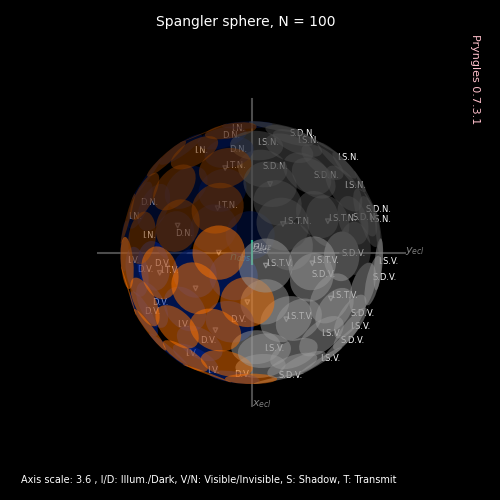

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.2})


<IPython.core.display.Javascript object>


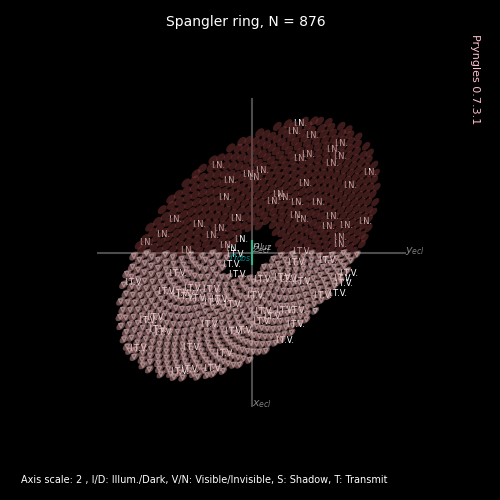

.
----------------------------------------------------------------------
Ran 1 test in 0.696s

OK


In [220]:
if IN_JUPYTER:
    def test_plot3d(self):
        global sg
        Verbose.VERBOSITY=VERB_SIMPLE

        #Sphere
        sg=Spangler(nspangles=100)
        sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ICE,preset=0,scale=3)
        sg.reset_state()
        
        cond=sg.data.z_ecl>0
        sg.data.loc[cond,"illuminated"]=True
        cond=sg.data.x_ecl>0
        sg.data.loc[cond,"visible"]=True
        cond=sg.data.y_ecl>0
        sg.data.loc[cond,"shadow"]=True
        cond=sg.data.f_equ>45*Consts.deg
        sg.data.loc[cond,"transmit"]=True

        sg.plot3d(statemark=0.5)
    
        #No preset
        sg=Spangler(nspangles=850,n_equ=[1,1,1])
        sg.populate_spangler(shape="ring",preset=True,
                             spangle_type=SPANGLE_GRANULAR,
                             scale=2,ri=0.2)
        sg.data.illuminated=True
        sg.data.illuminated=True
        cond=sg.data.x_ecl>0
        sg.data.loc[cond,"visible"]=True
        sg.data.loc[cond,"transmit"]=True
        sg.plot3d(statemark=0.1)
    
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_plot3d=test_plot3d
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Set intersection, observer, light-source

In [221]:
def set_intersect(self,
                  nvec=[0,0,1],
                  alpha=0,
                  center=None,
                  sphash=None,
                 ):
    """Set the positions and orientation of spanglers in an intersection direction

    Parameters:

        nvec: list/array (3), default = [0,0,1]:
            Vector pointing towards the vantage point from where the intersection will be computed. 
            It can be normalized or not.  The components are in the ecliptic reference system.
                        
        alpha: float, default = 0:
            Roll angle of x-axis.
            
        center: list/array (3), default = None:
            Location of the vantage point in the ecliptic reference system.
            If None, we assume that the vantage point is at an infinite distance.
            
        sphash: string, default = None:
            Spangler hash to which the transformation will be applied.

    Return:
    
        cond: boolean array:
            Over which spangles the transformation was applied.
            
        n_int: array (3):
            Normal vector towards the vantage point.
            
        d_int: float:
            Distance to vantage point.  If 'center' is None, this distance is set to numpy.inf.
            
    Create:
    
        qhulls: dictionary:
            Convex hulls of bodies from this vantage point.
            
            key: 
                sphash
            
            value: 
                list with hulls corresponding to each sphash.
            
    Update:

        Coordinates of the spangles in the intersection system, (x_int,y_int,z_int).

        Normal to spangles in the intersection system, ns_int.

    """
    
    verbose(VERB_SIMPLE,
            f"Setting intersect using nvec = {nvec}, alpha = {alpha} center = {center}, sphash = {sphash}")
    
    verbose(VERB_VERIFY,f"Generating intersection matrices from pvec = {nvec}")

    #Unitary observer vector
    n_int,norm=spy.unorm(nvec)
    alpha_int=alpha
    
    #Store n_int and d_int for update state purposes
    self.rqf_int=sci.spherical(n_int)
    self.n_int=n_int
    
    #Distance to center
    if center is None:
        self.infinite=True
        d_int=np.inf
        center=np.array([0,0,0])
    else:
        self.infinite=False
        d_int=np.linalg.norm(center)
        center=np.array(center)
    self.d_int=d_int

    #Transformation matrices
    M_int2ecl,self.M_ecl2int=Science.rotation_matrix(n_int,alpha_int)
    
    #Depending on body
    cond=[True]*self.nspangles
    if sphash:
        cond=(self.data.sphash==sphash)

    #If no point is of type sphash
    if sum(cond)==0:
        return
        
    #Update positions
    self.data.loc[cond,["x_int","y_int","z_int"]]=\
        [np.matmul(self.M_ecl2int,r-center) for r in np.array(self.data[cond][["x_ecl","y_ecl","z_ecl"]])]
    
    #Center of the object in the observer reference system
    center_int=[np.matmul(self.M_ecl2int,c_ecl+np.matmul(self.M_equ2ecl[sp],c_equ)-center)\
               for sp,c_ecl,c_equ in zip(self.data[cond].sphash,
                                         np.array(self.data[cond].center_ecl),
                                         np.array(self.data[cond].center_equ))]
    self.data.loc[cond,"center_int"]=pd.Series(center_int)
    
    if self.infinite:
        self.data.loc[cond,"z_cen_int"]=-np.inf
    else:
        self.data.loc[cond,"z_cen_int"]=np.array(center_int)[:,2]

    #Pseudo-cylindrical coordinates in the observer system
    self.data.loc[cond,["rho_int","az_int","cost_int"]]=\
        [sci.pcylindrical(r) for r in \
         np.array(self.data[cond][["x_int","y_int","z_int"]])-np.vstack(self.data[cond].center_int)]

    #Compute distance to light-source of each spangle
    if self.infinite:
        #Distance to all points is assumed infinite
        self.data.loc[cond,"d_int"]=np.inf
    else:
        #Distance to origin of coordinates in the int system where the center is located
        self.data.loc[cond,"d_int"]=np.linalg.norm(sg.data[cond][["x_int","y_int","z_int"]],axis=1)
    
    #Asuming d_int > radius of the object

    #Direction of spangle with respect to direction
    self.data.loc[cond,"cos_int"]=[np.dot(n_ecl,n_int) for n_ecl in self.data.ns_ecl[cond]]
    
    #Update spangles orientations
    lista=[np.matmul(self.M_ecl2int,n_ecl) for n_ecl in self.data[cond].ns_ecl]
    self.data.loc[cond,"ns_int"]=pd.Series(lista,dtype=object).values

    return cond,n_int,d_int


def _calc_qhulls(self):
    
    """Compute convex hulls for a given intersection configuration
    """
    
    #Convex hulls
    for sphash in Misc.flatten([self.sphash]):

        self.qhulls[sphash]=[]
        cond_obj=(self.data.sphash==sphash)
        zcen=self.data[cond_obj].center_int.iloc[0][2]

        if (self.data[cond_obj].hidden).sum()==0:

            #Convex hull of whole objects
            cond_hull=(cond_obj)&(~self.data[cond_obj].hidden)
            verbose(VERB_SIMPLE,"Hull points (whole object):",sum(cond_hull))

            zmin,zmax=self.data[cond_hull]["z_int"].values.min(),self.data[cond_hull]["z_int"].values.max()
            zmed=0.5*(zmin+zmax)

            self.qhulls[sphash]+=[dict(
                sphash=sphash,
                hulltype="cen",
                zmin=zmin,zmax=zmax,zmed=zmed,zcen=zcen,
                qhull=Science.get_convexhull(self.data[cond_hull][["x_int","y_int"]])
            )]

        else:
            #Convex hull of objects with a hole (eg. rings)

            #Plane of rings
            cond_hidden=(cond_obj)&(self.data[cond_obj].hidden)
            hidden=self.data[cond_hidden][["x_int","y_int","z_int"]].values
            nhidden=len(hidden)
            p1,p2,p3=hidden[0],hidden[int(nhidden/3)],hidden[2*int(nhidden/3)]
            plane=Science.Plane(p1,p2,p3)

            #Convex hull of hidden points (the hole)
            cond_hull=(cond_obj)&(self.data[cond_obj].hidden)
            verbose(VERB_SIMPLE,"Hull points (hidden):",sum(cond_hull))
            zmin,zmax=self.data[cond_hull]["z_int"].values.min(),self.data[cond_hull]["z_int"].values.max()
            zmed=0.5*(zmin+zmax)

            self.qhulls[sphash]+=[dict(
                sphash=sphash,
                hulltype="hidden",
                zmin=zmin,zmax=zmax,zmed=zmed,zcen=zcen,
                qhull=Science.get_convexhull(self.data[cond_hull][["x_int","y_int"]]),
                plane=plane
            )]

            #Convex hull of no hidden points
            cond_hull=(cond_obj)&(~self.data[cond_obj].hidden)
            verbose(VERB_SIMPLE,"Hull points (visible ring):",sum(cond_hull))
            zmin,zmax=self.data[cond_hull]["z_int"].values.min(),self.data[cond_hull]["z_int"].values.max()
            zmed=0.5*(zmin+zmax)

            self.qhulls[sphash]+=[dict(
                sphash=sphash,
                hulltype="plane",
                zmin=zmin,zmax=zmax,zmed=zmed,zcen=zcen,
                qhull=Science.get_convexhull(self.data[cond_hull][["x_int","y_int"]]),
                plane=plane
            )]
                
Spangler.set_intersect=set_intersect
Spangler._calc_qhulls=_calc_qhulls

  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 1], alpha = 0 center = [0, 0, -1], sphash = Ring
  VERB1::_calc_qhulls:: Hull points (hidden): 11
  VERB1::_calc_qhulls:: Hull points (visible ring): 50


<IPython.core.display.Javascript object>


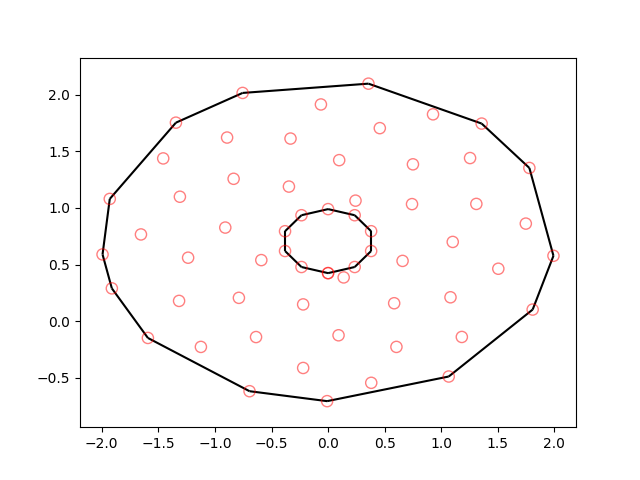

<IPython.core.display.Javascript object>


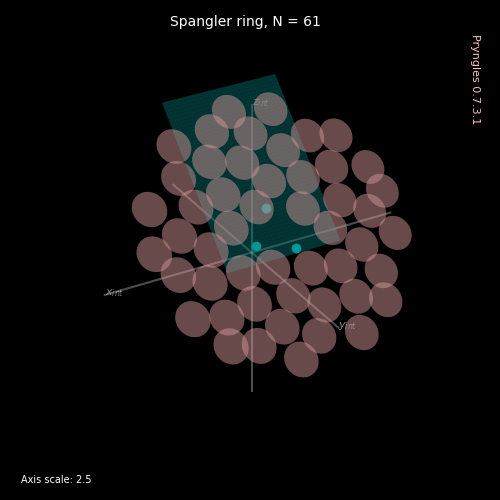

.

{'Ring': [{'sphash': 'Ring', 'hulltype': 'hidden', 'zmin': 0.4242640687119285, 'zmax': 0.9899494936611666, 'zmed': 0.7071067811865476, 'zcen': 0.7071067811865476, 'qhull': <scipy.spatial.qhull.ConvexHull object at 0x7fe7bb849100>, 'plane': <pryngles.science.Plane object at 0x7fe7bb849e20>}, {'sphash': 'Ring', 'hulltype': 'plane', 'zmin': -0.6844273378436135, 'zmax': 2.1213075340572636, 'zmed': 0.7184400981068251, 'zcen': 0.7071067811865476, 'qhull': <scipy.spatial.qhull.ConvexHull object at 0x7fe7bb849910>, 'plane': <pryngles.science.Plane object at 0x7fe7bb849e20>}]}



----------------------------------------------------------------------
Ran 1 test in 0.133s

OK


In [222]:
if IN_JUPYTER:
    
    def test_setint(self):
        global sg
        
        Verbose.VERBOSITY=VERB_SIMPLE

        #No preset
        sg=Spangler(nspangles=50,sphash="Ring")
        sg.populate_spangler(shape="ring",seed=1,
                             spangle_type=SPANGLE_GRANULAR,
                             scale=2,ri=0.2)
        sg.data.illuminated=True
        sg.data.visible=True
        
        cond,n_int,d_int=sg.set_intersect(nvec=[1,0,1],center=[0,0,-1],
                                          sphash="Ring")
        sg._calc_qhulls()
        
        #Plot convexhull
        from scipy.spatial import convex_hull_plot_2d
        fig,ax=plt.subplots()

        f=convex_hull_plot_2d(sg.qhulls["Ring"][0]["qhull"],ax)
        f=convex_hull_plot_2d(sg.qhulls["Ring"][1]["qhull"],ax)
        
        #Remove points corresponding to qhull
        for l in fig.axes[0].get_children():
            if type(l) is Line2D:
                plt.setp(l,ms=0,zorder=100)
    
        ax.scatter(sg.data.x_int,sg.data.y_int,color='r',s=65,fc="None",alpha=0.5,zorder=100)        
        ax.axis("equal")
            
        #Plot 3d
        sg.plot3d(coords="int")
        plane=sg.qhulls["Ring"][0]["plane"]
        plane.plot_plane(ax=sg.ax3d,color='c',alpha=0.5)

        #Hulls
        print(sg.qhulls)
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_setint=test_setint
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [223]:
def set_observer(self,nvec=[0,0,1],alpha=0,center=None):
    """Set the positions and orientation of spanglers in the observer system.

    Parameters:

        nvec: list/array (3), default = [0,0,1]:
            Normal vector towards the observer.

        alpha: float, default = 0:
            Roll angle of x-axis of observer system.
            
        center: list/array(3), default = None:
            Define the position of the vantage point in the ecliptic system.
            
    """
    verbose(VERB_SIMPLE,f"Setting observer")
    cond,self.n_obs,self.d_obs=self.set_intersect(nvec,alpha,center)
    self.rqf_obs=sci.spherical(self.n_obs)
    self.data.loc[cond,SPANGLER_COL_OBS]=self.data.loc[cond,SPANGLER_COL_INT].values
    
    #Update states
    self.data.unset=False
    
    #Condition for visibility
    """
    & ! Hidden
    & z_cen_obs < 0: spangle is observable from the observer vantage point-
        (
            | cos_obs > 0: spangle it is towards the observer
            | Spangle type is semitransparent
        )
    """
    cond=\
    (~self.data.hidden)&\
    (self.data.z_cen_obs<0)&\
    (\
        (self.data.cos_obs>0)|\
        (self.data.spangle_type.isin(SPANGLES_SEMITRANSPARENT))
    )
    self.data.loc[cond,"visible"]=True
    
def set_luz(self,nvec=[0,0,1],alpha=0,center=None,sphash=None):
    """Set the positions and orientation of spanglers in the light-source system.

    Parameters:

        nvec: list/array (3), default = [0,0,1]:
            Normal vector towards the observer.

        alpha: float, default = 0:
            Roll angle of x-axis of observer system.
            
        center: list/array(3), default = None:
            Define the position of the vantage point in the ecliptic system.

        sphash: string, default = None:
            Body to apply this light direction
            
    """
    verbose(VERB_SIMPLE,f"Setting light-source")
    cond,self.n_luz,self.d_luz=self.set_intersect(nvec,alpha,center,sphash)
    self.rqf_luz=sci.spherical(self.n_luz)
    self.data.loc[cond,SPANGLER_COL_LUZ]=deepcopy(self.data.loc[cond,SPANGLER_COL_INT].values)
    
    #Update states
    self.data.loc[cond,"unset"]=False
    
    #Condition for illumination
    """
    & ! Hidden
    & z_cen_luz < 0: spangle is in front of the light-source.
        (
            | geometry = circle : 2d spangles are always illuminated
            | spangle_type = stellar: stellar spangles are always illuminated
            | cos_luz > 0: spangle it is towards the light source
        )
    """
    cond=\
    cond&\
    (~self.data.hidden)&\
    (self.data.z_cen_luz<0)&\
    (\
        (self.data.geometry==SAMPLER_GEOMETRY_CIRCLE)|\
        (self.data.cos_luz>0)|\
        (self.data.spangle_type==SPANGLE_STELLAR)
    )
    self.data.loc[cond,"illuminated"]=True

    #Conditions for transmission:
    """
    & No hidden
    (
        & Spangle type is semitransparent
        & cos_obs . cos_luz < 0: observer and light source are in opposite sides
    )
    """
    cond=\
    cond&\
    (~self.data.hidden)&\
    (\
     (self.data.spangle_type.isin(SPANGLES_SEMITRANSPARENT))&\
     ((self.data.cos_luz*self.data.cos_obs)<=0)
    )
    self.data.loc[cond,"transmit"]=True

Spangler.set_observer=set_observer
Spangler.set_luz=set_luz

  VERB1::purge_sample:: Purging sample


,sphash,spangle_type,geometry,x_obs,y_obs,z_obs,d_obs,cos_obs,x_luz,y_luz,z_luz,d_luz,cos_luz,x_int,y_int,z_int,unset,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False
1,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False
2,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False
3,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False
4,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False
5,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False
6,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False
7,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False
8,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False
9,Planet,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,True,False,False,False,False,False,False,False,False,False,False


  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = [0, 0, 0], sphash = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = [0, 0, 0], sphash = None


<IPython.core.display.Javascript object>


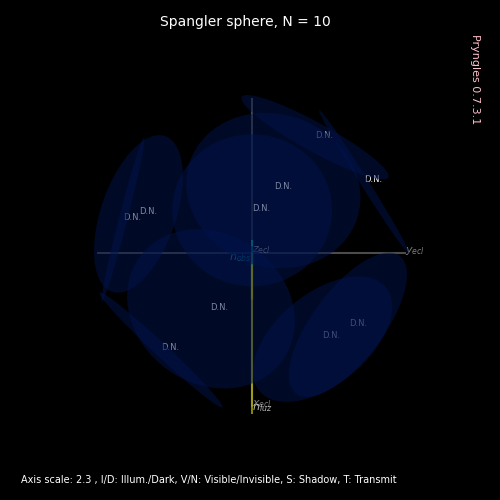

  VERB1::purge_sample:: Purging sample
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, sphash = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = [0, 0, 1], sphash = Planet


<IPython.core.display.Javascript object>


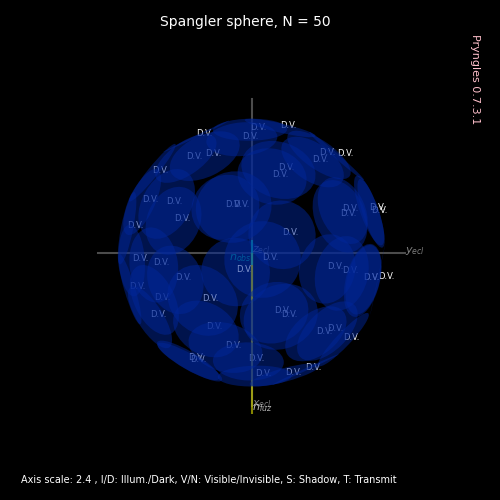

.
----------------------------------------------------------------------
Ran 1 test in 0.260s

OK


In [224]:
if IN_JUPYTER:
    def test_setobsluz(self):
        global sg
        
        Verbose.VERBOSITY=VERB_SIMPLE

        nspangles=10
        sg=Spangler(nspangles=nspangles,n_equ=[1,0,1],sphash="Planet")
        sg.populate_spangler(shape="sphere",preset=0,
                             spangle_type=SPANGLE_SOLID_ROCK,
                             scale=2)

        print_df(sg.data.loc[~sg.data.hidden,SPANGLER_KEY_FIELDS])

        sg.set_observer(nvec=[0,0,+1],center=[0,0,0])
        sg.set_luz(nvec=[+1,0,0],center=[0,0,0])

        sg.plot3d(statemark=1)

        #Semitransparen
        nspangles=50
        sg=Spangler(nspangles=nspangles,n_equ=[1,0,1],sphash="Planet")
        sg.populate_spangler(shape="sphere",preset=0,
                             spangle_type=SPANGLE_GASEOUS, #SPANGLE_SOLID_ROCK,
                             scale=2)
        sg.set_observer(nvec=[0,0,+1],center=None)
        sg.set_luz(nvec=[+1,0,0],center=[0,0,1],sphash="Planet")
        sg.plot3d(statemark=1)

         
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_setobsluz=test_setobsluz
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.3})
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, sphash = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 1, -1], alpha = 0 center = None, sphash = None


<IPython.core.display.Javascript object>


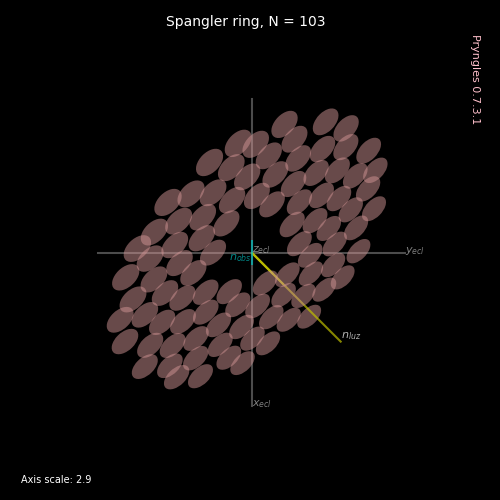

  VERB1::__init__:: Loading sampler from preset: ('ring', {'ri': 0.3})
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, sphash = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [-1, -1, -1], alpha = 0 center = None, sphash = None


<IPython.core.display.Javascript object>


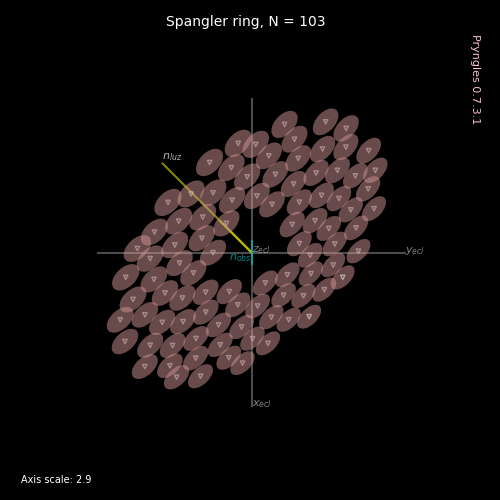

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 1], alpha = 0 center = None, sphash = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, sphash = None


<IPython.core.display.Javascript object>


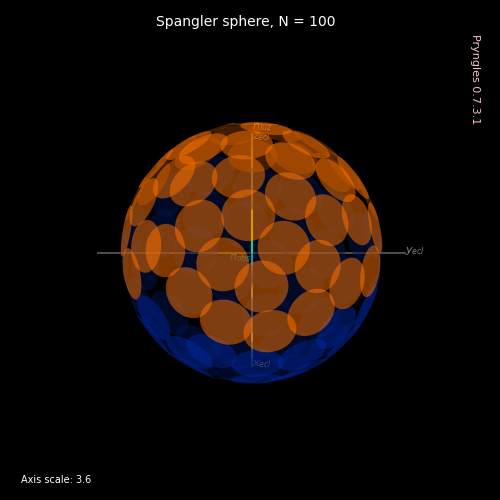

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 1], alpha = 0 center = None, sphash = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, sphash = None


<IPython.core.display.Javascript object>


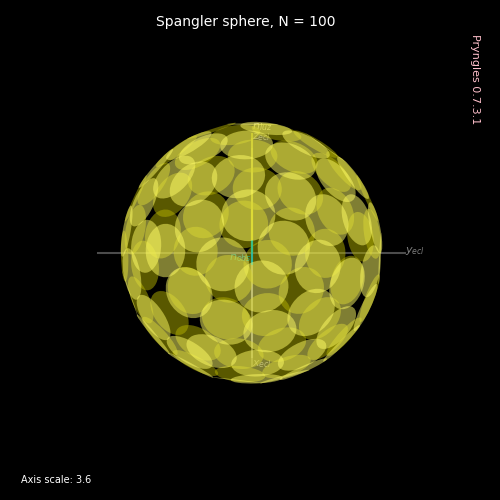

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 0, 1], alpha = 0 center = None, sphash = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = None, sphash = None


<IPython.core.display.Javascript object>


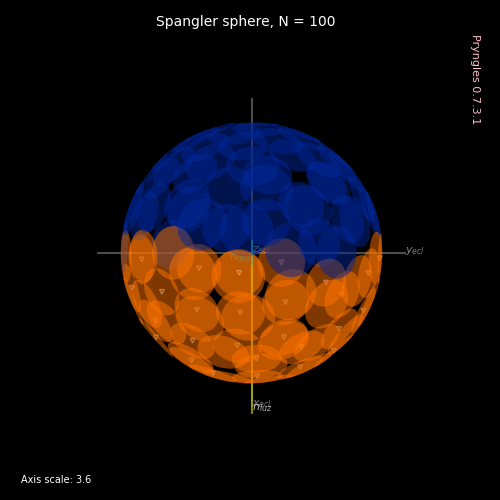

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 1, 0], alpha = 0 center = None, sphash = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = [0, 0, 0], sphash = Planet 1
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [-1, 0, 0], alpha = 0 center = [0, 0, 0], sphash = Planet 2


<IPython.core.display.Javascript object>


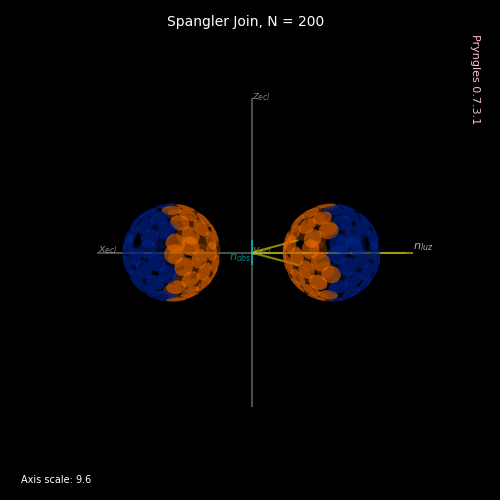

.
----------------------------------------------------------------------
Ran 1 test in 1.402s

OK


In [225]:
if IN_JUPYTER:
    def test_simplevis(self):
        global sg
        
        Verbose.VERBOSITY=VERB_SIMPLE

        plt.close("all")
        #Ring with semitransparent spangle: all illuminated, all visible, no transmission
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(shape="ring",ri=0.3,spangle_type=SPANGLE_GRANULAR,preset=True,scale=3)
        sg.set_observer([0,0,1])
        sg.set_luz([1,1,-1])
        sg.plot3d()

        #Ring with semitransparent spangle: all illuminated, all visible, no transmission
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(shape="ring",ri=0.3,spangle_type=SPANGLE_GRANULAR,preset=True,scale=3)
        sg.set_observer([0,0,1])
        sg.set_luz([-1,-1,-1])
        sg.plot3d()
        
        #Sphere with solid spangle: only illuminated 
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,preset=True,scale=3)
        sg.set_observer([1,0,1])
        sg.set_luz([0,0,1])
        sg.plot3d()
        
        #Sphere with stellar spangle: all illuminated, not all visible
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_STELLAR,preset=True,scale=3)
        sg.set_observer([1,0,1])
        sg.set_luz([0,0,1])
        sg.plot3d()

        #Sphere with semitransparent spangle: all illuminated, all visible
        sg=Spangler(nspangles=100,n_equ=[1,1,1])
        sg.populate_spangler(shape="sphere",spangle_type=SPANGLE_GASEOUS,preset=True,scale=3)
        sg.set_observer([0,0,1])
        sg.set_luz([1,0,0])
        sg.plot3d()

        #Two spheres
        sg1=Spangler(sphash="Planet 1",nspangles=100,center_equ=[-5,0,0])
        sg1.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ICE,preset=True,scale=3)
        
        sg2=Spangler(sphash="Planet 2",nspangles=100,center_equ=[+5,0,0])
        sg2.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,preset=True,scale=3)
        
        sg=Spangler(spanglers=[sg1,sg2])

        sg.set_observer([0,1,0])
        sg.set_luz(nvec=[1,0,0],center=[0,0,0],sphash="Planet 1")
        sg.set_luz(nvec=[-1,0,0],center=[0,0,0],sphash="Planet 2")
        
        sg.plot3d()
        return
        
        Verbose.VERBOSITY=VERB_NONE
        
    class Test(unittest.TestCase):pass
    Test.test_simplevis=test_simplevis
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

  VERB1::purge_sample:: Purging sample
  VERB1::purge_sample:: Purging sample
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect using nvec = [0, 1, 0], alpha = 0 center = None, sphash = None
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect using nvec = [1, 0, 0], alpha = 0 center = [0, 0, 0], sphash = None


<IPython.core.display.Javascript object>


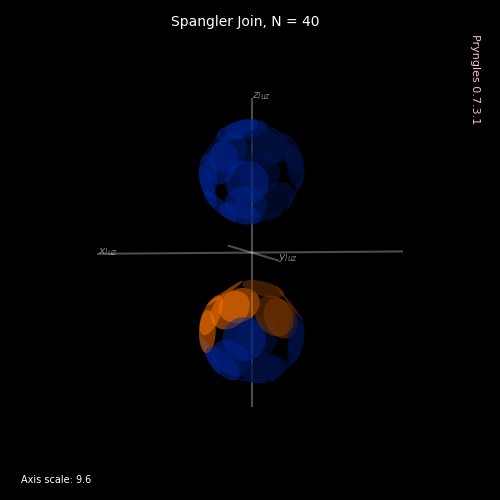

In [210]:
#Two spheres
nspangles=20

sg1=Spangler(sphash="Planet 1",nspangles=nspangles,center_equ=[-5,0,0])
sg1.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ICE,preset=0,scale=3)

sg2=Spangler(sphash="Planet 2",nspangles=nspangles,center_equ=[+5,0,0])
sg2.populate_spangler(shape="sphere",spangle_type=SPANGLE_SOLID_ROCK,preset=0,scale=3)

sg=Spangler(spanglers=[sg1,sg2])

sg.reset_state()
sg.set_observer([0,1,0])
sg.set_luz(nvec=[1,0,0],center=[0,0,0])#,sphash="Planet 1")
#sg.set_luz(nvec=[0,0,1],sphash="Planet 2")

sg.plot3d(coords="luz")

In [132]:
print_df(sg.data[SPANGLER_KEY_FIELDS])

,sphash,spangle_type,geometry,x_obs,y_obs,z_obs,x_luz,y_luz,z_luz,x_int,y_int,z_int,unset,visible,intersect,shadow,indirect,emit,above,illuminated,transmit,transit,occult
0,Planet 1,1,1,5.925034,-2.85,0.147687,0.147687,-2.85,-5.925034,0.147687,-2.85,-5.925034,False,True,False,False,False,False,False,False,False,False,False
1,Planet 1,1,1,4.017577,-2.55,-1.237879,-1.237879,-2.55,-4.017577,-1.237879,-2.55,-4.017577,False,False,False,False,False,False,False,True,False,False,False
2,Planet 1,1,1,4.859663,-2.25,1.979345,1.979345,-2.25,-4.859663,1.979345,-2.25,-4.859663,False,True,False,False,False,False,False,True,False,False,False
3,Planet 1,1,1,6.655018,-1.95,-1.567934,-1.567934,-1.95,-6.655018,-1.567934,-1.95,-6.655018,False,False,False,False,False,False,False,False,False,False,False
4,Planet 1,1,1,2.494858,-1.65,0.041978,0.041978,-1.65,-2.494858,0.041978,-1.65,-2.494858,False,True,False,False,False,False,False,True,False,False,False
5,Planet 1,1,1,7.005518,-1.35,1.776344,1.776344,-1.35,-7.005518,1.776344,-1.35,-7.005518,False,True,False,False,False,False,False,False,False,False,False
6,Planet 1,1,1,4.707442,-1.05,-2.794979,-2.794979,-1.05,-4.707442,-2.794979,-1.05,-4.707442,False,False,False,False,False,False,False,True,False,False,False
7,Planet 1,1,1,3.271516,-0.75,2.334490,2.334490,-0.75,-3.271516,2.334490,-0.75,-3.271516,False,True,False,False,False,False,False,True,False,False,False
8,Planet 1,1,1,7.911651,-0.45,-0.565497,-0.565497,-0.45,-7.911651,-0.565497,-0.45,-7.911651,False,False,False,False,False,False,False,False,False,False,False
9,Planet 1,1,1,5.434780,-0.15,2.964535,2.964535,-0.15,-5.434780,2.964535,-0.15,-5.434780,False,True,False,False,False,False,False,False,False,False,False


### Plot observer

In [45]:
def plot_obs(self,show_hidden=False,center_at=None,not_plot=[],**args):
    """
    Plot spangle.

    Optional parameters:
    
        show_hidden: boolean, default = True:
            If True show hidden spangles (used to create convex hull of objects).
            
        center_at: string, default = None:
            Hash of the object around which the plotting will be centered at (see sphash column
            of the Spangler DataFrame).
            
        args: dictionary, default = dict(c='c',s=0.1):
            Scatter plotting options, dictionary.
    """
    sargs=dict(c='c',sizes=3.5)
    sargs.update(args)
    bgcolor='k'

    #Center of plot
    cond=(self.data.sphash==center_at)
    x_cen,y_cen,z_cen=self.data[cond][["x_obs","y_obs","z_obs"]].mean() if sum(cond)>0 else np.array([0,0,0])

    #Maxval original
    maxval_full=1.2*np.abs(self.data[["x_obs","y_obs"]].to_numpy()-[x_cen,y_cen]).max()

    #Select plotting bodies
    yes_plot=(~self.data.sphash.isin(not_plot))
    nyes_plot=sum(yes_plot)
    if nyes_plot==0:
        raise AssertionError(f"No body remain after removing {not_plot}")
    data=self.data[yes_plot]
    
    #Select scale for plot
    cond=cond if sum(cond)>0 else [True]*nyes_plot        
    maxval=1.2*np.abs(data[cond][["x_obs","y_obs"]].to_numpy()-[x_cen,y_cen]).max()
    size_factor=maxval_full/maxval
        
    #Figure
    fig=plt.figure(figsize=(5,5))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,facecolor=bgcolor)
    ax.axis("off")

    #Plot according to state
    colors=np.array(['#000000']*nyes_plot) #Black
    sizes=np.array([0.0]*nyes_plot)

    #No illuminated
    cond=(data.visible)&(~data.illuminated)
    colors[cond]=Misc.rgb(SHADOW_COLOR_OBS,to_hex=True) #Gray
    sizes[cond]=3.5*size_factor*data.scale[cond]

    #Illuminated
    cond=(data.visible)&(data.illuminated)
    colors[cond]=[Misc.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1),
                            SPANGLE_COLORS[stype][2]],
                            to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].spangle_type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=3.5*size_factor*data.scale[cond]

    #Transmit
    cond=(data.visible)&(data.transmit)
    colors[cond]=[Misc.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1),
                            SPANGLE_COLORS[stype][2]],
                            to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].spangle_type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=0.5*size_factor*data.scale[cond]

    #No illuminated
    cond=(data.unset)
    colors[cond]=Misc.rgb(SHADOW_COLOR_OBS,to_hex=True) #Gray
    sizes[cond]=3.5*size_factor*data.scale[cond]
    
    #Plots
    sargs.update(dict(c=colors,sizes=sizes))    
    ax.scatter(data.x_obs-x_cen,data.y_obs-y_cen,**sargs)
    
    #Show hidden spangles
    if show_hidden:
        cond=(self.data.hidden)
        sargs.update(dict(c='r',sizes=1.5*data.scale[cond],ec='r',fc='r'))    
        ax.scatter(data.x_obs[cond]-x_cen,data.y_obs[cond]-y_cen,**sargs)

    #Ranges
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    
    factor=1
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],'w-',alpha=0.3)
    ax.text(xmax,0,r"$x_{obs}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,r"$y_{obs}$",color='w',alpha=0.5,fontsize=8)

    #Title
    lamb_obs=self.rqf_obs[1]*Consts.rad
    phi_obs=self.rqf_obs[2]*Consts.rad        
    label_obs=f"Obs ($\lambda$,$\\beta$) : ({lamb_obs:.1f}$^\circ$,{phi_obs:.1f}$^\circ$)"
    ax.set_title(f"Spangler {self.geometry}, N = {self.nspangles}, {label_obs}",
                 color='w',fontsize=10,position=(0.5,+0.5),ha='center')
    Plot.pryngles_mark(ax)

    #Scale
    center_text=""
    if center_at:
        center_text=f", Center at '{center_at}'"
    ax.text(0,0,f"Axis scale: {maxval*factor:.2g}{center_text}",
              fontsize=8,color='w',
              transform=ax.transAxes)

    #Decoration
    ax.axis("equal")
    fig.tight_layout()
    self.fig2d=fig
    self.ax2d=ax

Spangler.plot_obs=plot_obs

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (whole object): 2584
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (whole object): 2584


<IPython.core.display.Javascript object>


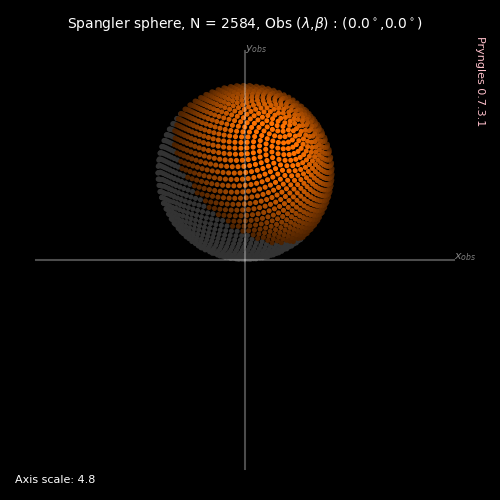

.
----------------------------------------------------------------------
Ran 1 test in 0.575s

OK


In [46]:
if IN_JUPYTER:
    def test_plotobs(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE
        
        plt.close("all")
        sg=Spangler(nspangles=2500,sphash="123",n_equ=[1,1,1],center_ecl=[0,0,2])
        sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=2,seed=1,preset=True)
        sg.set_observer(nvec=[1,0,0])
        sg.set_luz(nvec=[1,1,1])
        sg.update_simple_state()
        sg.plot_obs()
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plotobs=test_plotobs
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [221]:
def plot2d(self,
           coords="obs",
           only=None,
           center_at=None,
           not_plot=[],
           fsize=5,
           show_hidden=False):
    """
    Plot spangle.

    Optional parameters:
    
        only: string, default = None:
            Plot only the object with this hash.
                    
        center_at: string, default = None:
            Hash of the object around which the plotting will be centered at (see sphash column
            of the Spangler DataFrame).
            
        not_plot: list of strings, default = []:
            List of objects (hashes) to not plot.
        
        show_hidden: boolean, default = True:
            If True show hidden spangles (used to create convex hull of objects).
            
    """

    #Plot only a given object
    if only:
        not_plot=list(self.data.sphash.unique())
        if only not in not_plot:
            raise ValueError(f"Spangler '{only}' not among available spanglers ({not_plot})")
        else:
            not_plot.remove(only)
            center_at=only

    bgcolor='k'

    #Center of plot
    cond=(self.data.sphash==center_at)
    x_cen,y_cen,z_cen=self.data[cond][[f"x_{coords}",f"y_{coords}",f"z_{coords}"]].mean() if sum(cond)>0 else np.array([0,0,0])

    #Maxval original
    maxval_full=1.2*np.abs(self.data[[f"x_{coords}",f"y_{coords}"]].to_numpy()-[x_cen,y_cen]).max()

    #Select plotting bodies
    yes_plot=(~self.data.sphash.isin(not_plot))
    nyes_plot=sum(yes_plot)
    if nyes_plot==0:
        raise AssertionError(f"No body remain after removing {not_plot}")
    data=self.data[yes_plot]
    
    #Select scale for plot
    cond=cond if sum(cond)>0 else [True]*nyes_plot        
    maxval=1.2*np.abs(data[cond][[f"x_{coords}",f"y_{coords}"]].to_numpy()-[x_cen,y_cen]).max()
    size_factor=maxval_full/maxval
        
    #Figure
    fig=plt.figure(figsize=(fsize,fsize))
    fig.patch.set_facecolor(bgcolor)
    ax=fig.add_subplot(111,facecolor=bgcolor)
    ax.axis("off")

    #Plot according to state
    colors=np.array(['#000000']*nyes_plot) #Black
    sizes=np.array([0.0]*nyes_plot)

    #No illuminated
    cond=(data.visible)&(~data.illuminated)
    colors[cond]=Misc.rgb(SHADOW_COLOR_OBS,to_hex=True) #Gray
    sizes[cond]=3.5*size_factor*data.scale[cond]

    #Illuminated
    cond=(data.visible)&(data.illuminated)
    colors[cond]=[Misc.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1),
                            SPANGLE_COLORS[stype][2]],
                            to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].spangle_type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=3.5*size_factor*data.scale[cond]

    #Transmit
    cond=(data.visible)&(data.transmit)
    colors[cond]=[Misc.rgb([SPANGLE_COLORS[stype][0],
                            SPANGLE_COLORS[stype][1]*min((cos_luz*cos_obs+0.3),1),
                            SPANGLE_COLORS[stype][2]],
                            to_hex=True) for stype,cos_luz,cos_obs in zip(data[cond].spangle_type,
                                                                       abs(data[cond].cos_luz),
                                                                       abs(data[cond].cos_obs))
                 ] #Object color
    sizes[cond]=0.5*size_factor*data.scale[cond]

    #No illuminated
    cond=(data.unset)
    colors[cond]=Misc.rgb(SHADOW_COLOR_OBS,to_hex=True) #Gray
    sizes[cond]=3.5*size_factor*data.scale[cond]
    
    #Plots
    sargs=dict(c=colors,sizes=sizes)
    ax.scatter(data[f"x_{coords}"]-x_cen,data[f"y_{coords}"]-y_cen,**sargs)
    
    #Show hidden spangles
    if show_hidden:
        cond=(self.data.hidden)
        sargs=dict(c='r',sizes=1.5*data.scale[cond],ec='r',fc='r')    
        ax.scatter(data.loc[cond,f"x_{coords}"]-x_cen,data.loc[cond,f"x_{coords}"]-y_cen,**sargs)

    #Ranges
    ax.set_xlim(-maxval,maxval)
    ax.set_ylim(-maxval,maxval)
    
    factor=1
    xmin,xmax=factor*np.array(list(ax.get_xlim()))
    ymin,ymax=factor*np.array(list(ax.get_ylim()))

    #Axis
    ax.plot([xmin,xmax],[0,0],'w-',alpha=0.3)
    ax.plot([0,0],[ymin,ymax],'w-',alpha=0.3)
    ax.text(xmax,0,fr"$x_{{{coords}}}$",color='w',alpha=0.5,fontsize=8)
    ax.text(0,ymax,fr"$y_{{{coords}}}$",color='w',alpha=0.5,fontsize=8)

    #Title
    label_obs=""
    lamb=0
    phi=0
    if coords=="obs":
        lamb=self.rqf_obs[1]*Consts.rad
        phi=self.rqf_obs[2]*Consts.rad        
    elif coords=="luz":
        lamb=self.rqf_luz[1]*Consts.rad
        phi=self.rqf_luz[2]*Consts.rad
    elif coords=="int":
        lamb=self.rqf_int[1]*Consts.rad
        phi=self.rqf_int[2]*Consts.rad
        
    label_obs=f"{coords} ($\lambda$,$\\beta$) : ({lamb:.1f}$^\circ$,{phi:.1f}$^\circ$)"
    ax.set_title(f"{label_obs}",
                 color='w',fontsize=10,position=(0.5,+0.5),ha='center')
        
    #Water mark
    Plot.pryngles_mark(ax)

    #Scale
    center_text=""
    if center_at:
        center_text=f", Center at '{center_at}'"
    ax.text(0,0,f"Axis scale: {maxval*factor:.2g}{center_text}",
              fontsize=8,color='w',
              transform=ax.transAxes)

    #Decoration
    ax.axis("equal")
    fig.tight_layout()
    self.fig2d=fig
    self.ax2d=ax

Spangler.plot2d=plot2d

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (whole object): 2584
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (whole object): 2584


<IPython.core.display.Javascript object>


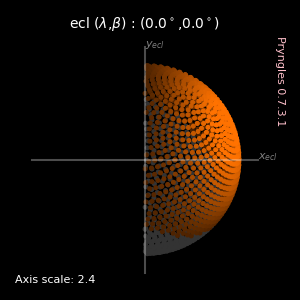

<IPython.core.display.Javascript object>


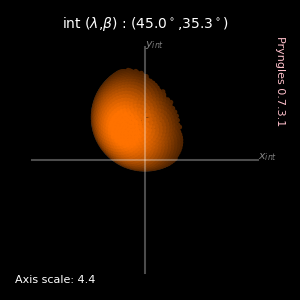

<IPython.core.display.Javascript object>


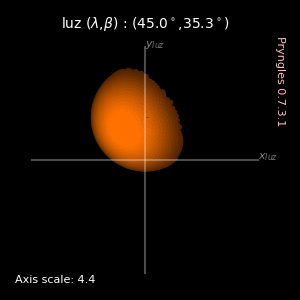

<IPython.core.display.Javascript object>


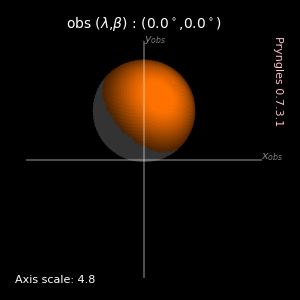

.
----------------------------------------------------------------------
Ran 1 test in 0.697s

OK


In [222]:
if IN_JUPYTER:
    def test_plot2d(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE
        
        plt.close("all")
        sg=Spangler(nspangles=2500,sphash="123",n_equ=[1,1,1],center_ecl=[0,0,2])
        sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=2,seed=1,preset=True)
        sg.set_observer(nvec=[1,0,0])
        sg.set_luz(nvec=[1,1,1])
        sg.update_simple_state()
        fs=3
        sg.plot2d(coords="ecl",fsize=fs)
        sg.plot2d(coords="int",fsize=fs)
        sg.plot2d(coords="luz",fsize=fs)
        sg.plot2d(coords="obs",fsize=fs)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plot2d=test_plot2d
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Test join

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (hidden): 100
  VERB1::set_intersect:: Hull points (visible ring): 1000
  VERB1::set_intersect:: Hull points (whole object): 987
  VERB1::set_luz:: Setting light-source
  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (hidden): 100
  VERB1::set_intersect:: Hull points (visible ring): 1000
  VERB1::set_intersect:: Hull points (whole object): 987


<IPython.core.display.Javascript object>


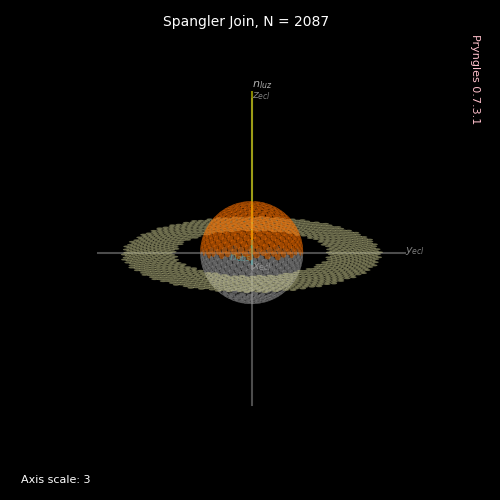

<IPython.core.display.Javascript object>


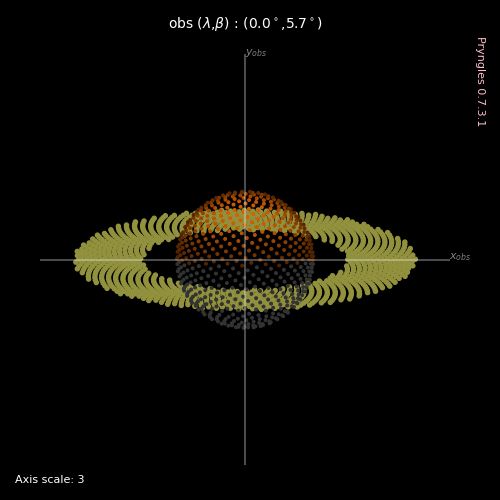

.
----------------------------------------------------------------------
Ran 1 test in 1.804s

OK


In [223]:
if IN_JUPYTER:
    def test_join(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE

        sg1=Spangler(nspangles=1000,sphash="Ring",n_equ=[1,0,5])
        sg1.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)

        sg2=Spangler(nspangles=1000,sphash="Planet",n_equ=[0,0,1])
        sg2.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)

        sgj=Spangler(spanglers=[sg1,sg2])
        
        sgj.set_observer([1,0,0.1])
        sgj.set_luz([0,0,1])
        sgj.update_simple_state()
        
        sgj.plot3d()
        sgj.plot2d()
        
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_join=test_join
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 2 spanglers
  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (hidden): 100
  VERB1::set_intersect:: Hull points (visible ring): 1000
  VERB1::set_intersect:: Hull points (whole object): 987


<IPython.core.display.Javascript object>


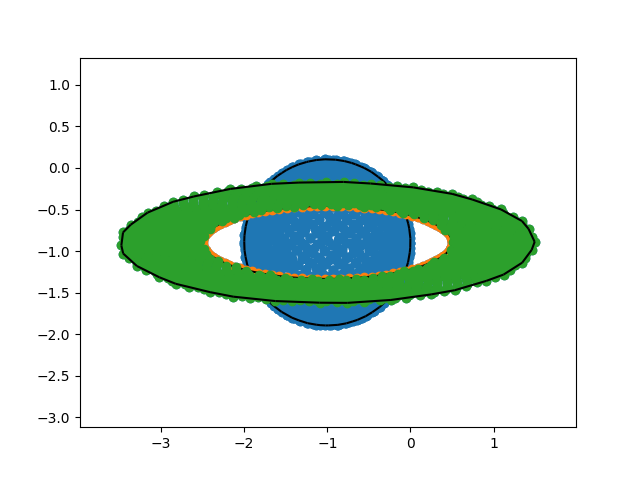

  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (hidden): 100
  VERB1::set_intersect:: Hull points (visible ring): 1000
  VERB1::set_intersect:: Hull points (whole object): 987


<IPython.core.display.Javascript object>


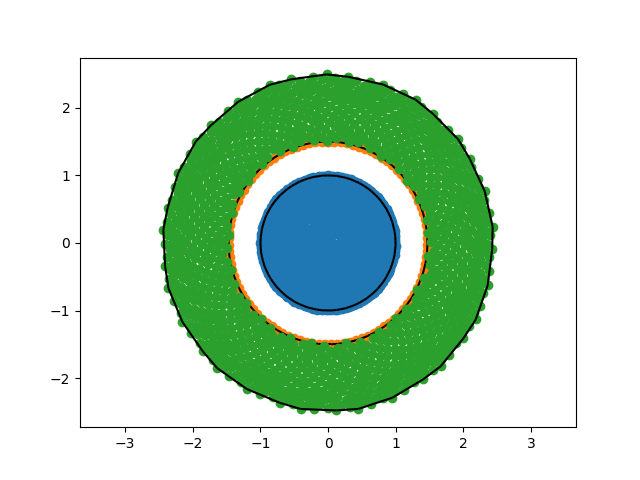

.
----------------------------------------------------------------------
Ran 1 test in 0.713s

OK


In [224]:
if IN_JUPYTER:
    def test_hulls(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE

        sg1=Spangler(nspangles=1000,sphash="Ring",n_equ=[1,0,5])
        sg1.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)
        sg2=Spangler(nspangles=1000,sphash="Planet",n_equ=[0,0,1])
        sg2.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)
        sgj=Spangler(spanglers=[sg1,sg2])
        
        #Hulls of obsever
        cond,n_int,d_int=sgj.set_intersect(nvec=[1,0,0.1],center=[1,1,1]) #Each time a set intersect is executed the convex hulls are renewed
        
        fig,ax=plt.subplots()
        ax.scatter(sgj.data[cond].x_int,sgj.data[cond].y_int)
        f=convex_hull_plot_2d(sgj.qhulls["Planet"][0]["qhull"],ax)
        ax.axis("equal")

        f=convex_hull_plot_2d(sgj.qhulls["Ring"][0]["qhull"],ax)
        f=convex_hull_plot_2d(sgj.qhulls["Ring"][1]["qhull"],ax)

        #Hulls of light
        sgj.set_intersect([0,0,1]) #Each time a set intersect is executed the convex hulls are renewed
        fig,ax=plt.subplots()
        cond=sgj.data.visible
        ax.scatter(sgj.data[cond].x_int,sgj.data[cond].y_int)
        f=convex_hull_plot_2d(sgj.qhulls["Planet"][0]["qhull"],ax)
        f=convex_hull_plot_2d(sgj.qhulls["Ring"][0]["qhull"],ax)
        f=convex_hull_plot_2d(sgj.qhulls["Ring"][1]["qhull"],ax)
        ax.axis("equal")
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_hulls=test_hulls
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

### Update intersection state

In [225]:
def update_intersection_state(self):
    """Update state of intersections
    """    
    #Check if an intersection has been computed
    if len(self.qhulls) == 0:
        raise AssertionError("You must set an intersection vantage point.")

    #Under the current circumstances all this spangles are intersecting 
    cond=(~self.data.hidden)&((self.data.cos_int>0)|(self.data.spangle_type.isin(SEMITRANSPARENT_SPANGLES)))
    self.data.loc[cond,"intersect"]=True
        
    for sphash in Misc.flatten([self.sphash]):
        
        cond=(self.data.sphash==sphash)
        inhull_not_in_hole=[True]
        
        verbose(VERB_SIMPLE,f"Calculating intersections for '{sphash}'")
        for i,hull in enumerate(self.qhulls[sphash]):
            
            qhull=hull["qhull"]
            if qhull is None:
                verbose(VERB_SIMPLE,f"No hull for '{sphash}'")
                continue
            
            htype=hull["hulltype"]
            zmin,zmed,zmax,zcen=hull["zmin"],hull["zmed"],hull["zmax"],hull["zcen"]
            
            verbose(VERB_SIMPLE,f"Hull {i+1} for '{sphash}' of type '{htype}'")

            #Evaluate conditions
            inhull=sci.points_in_hull(self.data[["x_int","y_int"]],qhull)&(~cond)
            below=np.array([False]*self.nspangles)
            
            if htype=="hidden":

                #Holes
                inhull_not_in_hole=(~inhull)
                verbose(VERB_SIMPLE,f"Points outside hidden hull for '{sphash}': {sum(inhull_not_in_hole)}")
                hull["notinhole"]=sum(inhull_not_in_hole)
                continue
                
            else:
                #Body
                verbose(VERB_SIMPLE,f"Points not in hole for '{sphash}:{htype}': {sum(inhull_not_in_hole)}")

                #Spangles to evaluate
                cond_int=(~self.data.hidden)&(self.data.sphash!=sphash)&(self.data.intersect)

                if htype=="min":
                    below=(inhull_not_in_hole)&(inhull)&(self.data[cond_int]["z_int"]<=zmin)
                    
                elif htype=="med":
                    below=(inhull_not_in_hole)&(inhull)&(self.data[cond_int]["z_int"]<=zmed)
                    
                elif htype=="max":
                    below=(inhull_not_in_hole)&(inhull)&(self.data[cond_int]["z_int"]<=zmax)
                    
                elif htype=="cen":
                    below=(inhull_not_in_hole)&(inhull)&(self.data[cond_int]["z_int"]<=zcen)
                    
                elif htype=="plane":
                    #Not in hole, inhull, not hidden, not in object and intersect
                    cond_full=(inhull_not_in_hole)&(inhull)&(cond_int)
                    verbose(VERB_SIMPLE,"Fulfilling all conditions:",sum(cond_full))
                    
                    plane=hull["plane"]
                    below[cond_full]=[plane.is_below(r,[0,0,1]) for r in self.data[cond_full][["x_int","y_int","z_int"]].values]
                else:
                    raise ValueError("Type of hull '{htype}' not recognized")
            
            #Store information
            verbose(VERB_SIMPLE,f"Points in hull for '{sphash}:{htype}': {sum(inhull)}")
            verbose(VERB_SIMPLE,f"Points below '{sphash}:{htype}': {sum(below)}")
            
            #Set visibility
            self.data.loc[below,"intersect"]=False

            hull["inhull"]=sum(inhull)
            hull["below"]=sum(below)
    
def update_visibility_state(self):
    self.update_intersection_state()
    self.data.visible=self.data.visible&self.data.intersect

def update_illumination_state(self):
    self.update_intersection_state()
    self.data.illuminated=self.data.illuminated&self.data.intersect

Spangler.update_intersection_state=update_intersection_state
Spangler.update_visibility_state=update_visibility_state
Spangler.update_illumination_state=update_illumination_state

In [226]:
"""
Verbose.VERBOSITY=VERB_SIMPLE
#Spanglers
nspangles=500
sps=[]
sg=Spangler(nspangles=nspangles,sphash="Parent",n_equ=[0,0,1],center_equ=[-7,0,0])
sg.populate_spangler(geometry="sphere",spangle_type=STELLAR_SPANGLE,scale=3,seed=1,preset=True)
sps+=[sg]
sg=Spangler(nspangles=nspangles,sphash="Planet",n_equ=[0,0,1])
sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)
sps+=[sg]
sg=Spangler(nspangles=nspangles,sphash="Ring",n_equ=[1,0,0])
sg.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)
sps+=[sg]
sg=Spangler(nspangles=nspangles,sphash="Moon",n_equ=[0,0,1],center_equ=[+3.0,0.0,0.0])
sg.populate_spangler(geometry="sphere",spangle_type=ATMOSPHERIC_SPANGLE,scale=0.3,seed=1,preset=True)
sps+=[sg]
sg=Spangler(spanglers=sps)

#Direction of observations
n_obs=sci.cartesian([1,30*Consts.deg,0*Consts.deg])
sg.set_observer(nvec=n_obs)
n_luz=sci.cartesian([1,0*Consts.deg,0*Consts.deg])
sg.set_luz(nvec=n_obs)

#Intersection state
sg.set_intersect(nvec=n_obs)
sg.update_intersection_state()
#print(sg.qhulls)

#Plot intersect
#fig=sg._plot_intersect()
#sg._interact_intersect()
Verbose.VERBOSITY=VERB_NONE
sg.plot3d(coords="int")
sg.data[sg.data.sphash=="Parent"].center_int.iloc[0]
#""";

In [51]:
def _plot_intersect(self,prop="intersect",fig=None):
    """Plot intersect
    
    Parameters:
    
        prop: string, default = intersect:
            Property to highlight.  Available: intersect, illuminated, visible.
            
        fig: Figure, default = None:
            Figure.
            
    Return:
    
        fig: Figure.
    """
    
    #Check if an intersection has been computed
    if len(self.qhulls) == 0:
        raise AssertionError("You must set an intersection vantage point.")    

    bgcolor='k'
    if fig is None:
        fig,ax=plt.subplots()
        fig.patch.set_facecolor(bgcolor)
        ax.axis("off")
    else:
        ax=fig.gca()

    #Plot qhulls and points
    for i,sphash in enumerate(Misc.flatten([self.sphash])):
        cond_obj=(self.data.sphash==sphash)
        cond=cond_obj&(~self.data.hidden)&(self.data[prop])
        
        s=1*self.data[cond].scale
        colors=[Misc.rgb(SPANGLE_COLORS[stype],to_hex=True) for stype in self.data[cond].spangle_type]
        ax.scatter(self.data[cond].x_int,self.data[cond].y_int,s=s,c=colors,zorder=100)
        
        #Plot qhull
        for hull in self.qhulls[sphash]:
            if hull["qhull"] is None:
                continue
            f=convex_hull_plot_2d(hull["qhull"],ax)

    #Remove points corresponding to qhull
    for l in fig.axes[0].get_children():
        if type(l) is Line2D:
            plt.setp(l,ms=0,zorder=100)
        if type(l) is LineCollection:
            l.set_color('w')
            
    #Decoration
    ax.set_xlabel(r"$x_{\rm int}$")
    ax.set_ylabel(r"$y_{\rm int}$")
    
    ax.grid()
    ax.axis("equal")
    
    return fig

def _view_intersect(self,lon=0,lat=0,fig=None):
    """Similar as _plot_intersect but for animation and interactive purposes.
    
    Parameters:
        long, lat: floats [deg], default = 0,0:
            Ecliptic longitud and latitude in degrees.
            
        fig: Figure, default = None.
            Figure.
    """
    
    #Input
    lon=float(lon)
    lat=float(lat)

    n_obs=sci.cartesian([1,lon*Consts.deg,lat*Consts.deg])
    cond=self.set_observer(nvec=n_obs,center=[0,0,0])

    self.reset_state()
    self.update_simple_state()
    self.update_visibility_state()
    fig=self._plot_intersect(prop="visible",fig=fig)
    
    #Decorate
    ax=fig.gca()
    ax.text(0.5,1.01,f"Observer: lon = {lon:+.2f}$^\circ$, lat = {lat:+.2f}$^\circ$",
            transform=ax.transAxes,ha='center',fontsize=10,color='w')

Spangler._plot_intersect=_plot_intersect
Spangler._view_intersect=_view_intersect

In [52]:
def _interact_intersect(self):
    
    verbosity=Verbose.VERBOSITY
    Verbose.VERBOSITY=VERB_NONE
    
    def view_intersect(**args):
        self._view_intersect(**args)
        
    opciones=dict(continuous_update=False,readout_format=".3f")
    interact(view_intersect,
             lon=widgets.FloatSlider(min=0,max=360,step=0.01,value=0,**opciones),
             lat=widgets.FloatSlider(min=-90,max=90,step=0.01,value=0,**opciones),
            );
    
    Verbose.VERBOSITY=verbosity

def _animate_intersect(self,filename=None,lat=20,start=0,stop=360,num=10):
    """Animate intersection state
    
    Notes:
        Based in: https://github.com/jwkvam/celluloid
    """
    
    verbosity=Verbose.VERBOSITY
    Verbose.VERBOSITY=VERB_NONE
    bgcolor='k'
    
    fig,ax=plt.subplots()
    fig.patch.set_facecolor(bgcolor)
    ax.axis("off")
    
    camera=Camera(fig)
    for lon in np.linspace(start,stop,num):
        self._view_intersect(lon=lon,lat=lat,fig=fig)
        camera.snap()
    anim=camera.animate()

    Verbose.VERBOSITY=verbosity
        
    if filename is not None:
        if 'gif' in filename:
            anim.save(filename)
            del anim
        elif 'mp4' in filename:
            ffmpeg=animation.writers["ffmpeg"]
            metadata = dict(title='Pryngles Spangler Animation',
                            artist='Matplotlib',
                            comment='Movie')
            w=ffmpeg(fps=15,metadata=metadata)
            anim.save(filename,w)
            del anim
        else:
            raise ValueError(f"Animation format '{filename}' not recognized")
    else:
        return anim

Spangler._interact_intersect=_interact_intersect
Spangler._animate_intersect=_animate_intersect

  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Loading sampler from preset: ('sphere', {})
  VERB1::purge_sample:: Already purged.
  VERB1::__init__:: Joining 4 spanglers
  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (whole object): 100
  VERB1::set_intersect:: Hull points (whole object): 100
  VERB1::set_intersect:: Hull points (hidden): 100
  VERB1::set_intersect:: Hull points (visible ring): 100
  VERB1::set_intersect:: Hull points (whole object): 100
  VERB1::update_intersection_state:: Calculating intersections for 'Parent'
  VERB1::update_intersection_state:: Hull 1 for 'Parent' of type 'cen'
  VERB1::update_intersection_state:: Points not in hole for 'Parent:cen': 1
  VERB1::update_intersection_state:: Points in hull for 'Paren

<IPython.core.display.Javascript object>


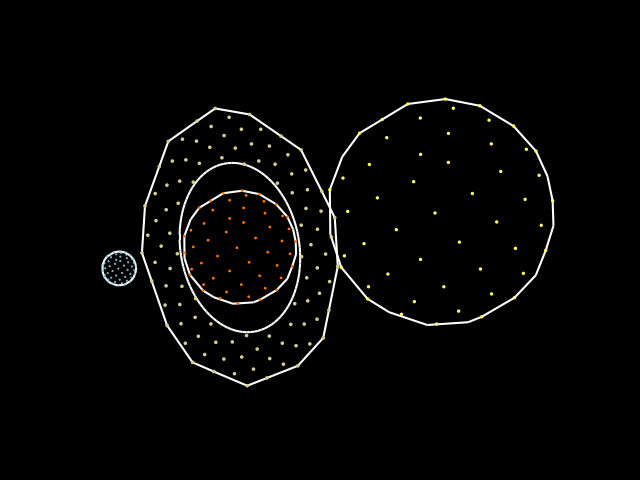

  VERB1::set_observer:: Setting observer
  VERB1::set_intersect:: Setting intersect
  VERB1::set_intersect:: Hull points (whole object): 100
  VERB1::set_intersect:: Hull points (whole object): 100
  VERB1::set_intersect:: Hull points (hidden): 100
  VERB1::set_intersect:: Hull points (visible ring): 100
  VERB1::set_intersect:: Hull points (whole object): 100
  VERB1::update_intersection_state:: Calculating intersections for 'Parent'
  VERB1::update_intersection_state:: Hull 1 for 'Parent' of type 'cen'
  VERB1::update_intersection_state:: Points not in hole for 'Parent:cen': 1
  VERB1::update_intersection_state:: Points in hull for 'Parent:cen': 0
  VERB1::update_intersection_state:: Points below 'Parent:cen': 0
  VERB1::update_intersection_state:: Calculating intersections for 'Planet'
  VERB1::update_intersection_state:: Hull 1 for 'Planet' of type 'cen'
  VERB1::update_intersection_state:: Points not in hole for 'Planet:cen': 1
  VERB1::update_intersection_state:: Points in hull f

<IPython.core.display.Javascript object>


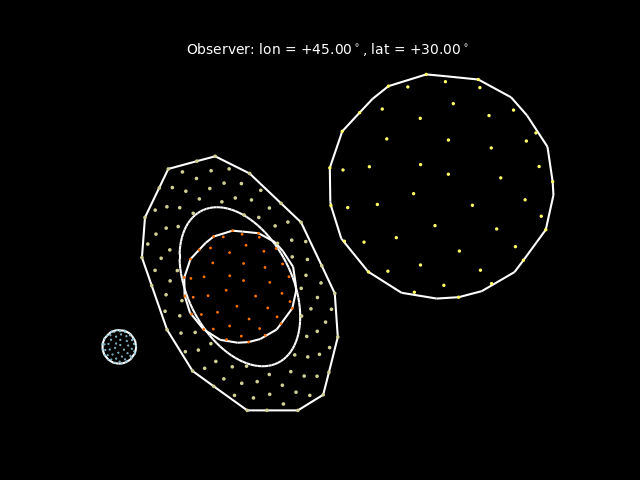

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='lon', max=360.0, readout_fo…

<IPython.core.display.Javascript object>


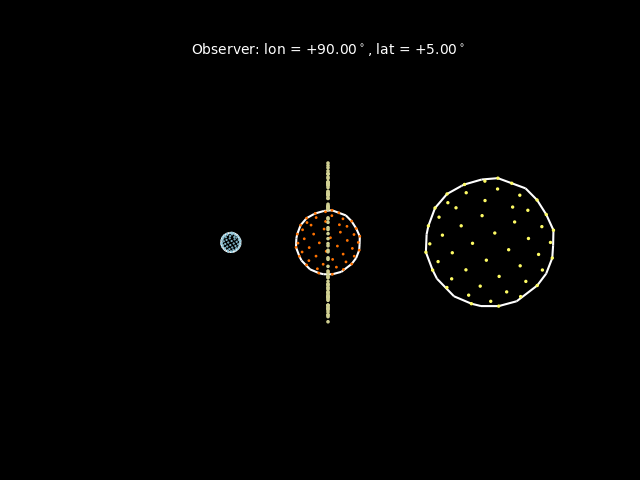

.
----------------------------------------------------------------------
Ran 1 test in 1.626s

OK


In [53]:
if IN_JUPYTER:
    def test_plotint(self):
        
        Verbose.VERBOSITY=VERB_SIMPLE
        
        plt.close("all")

        nspangles=100
        sps=[]
        sg=Spangler(nspangles=nspangles,sphash="Parent",n_equ=[0,0,1],center_equ=[-5,0,0])
        sg.populate_spangler(geometry="sphere",spangle_type=STELLAR_SPANGLE,scale=2,seed=1,preset=True)
        sps+=[sg]
        sg=Spangler(nspangles=nspangles,sphash="Planet",n_equ=[0,0,1])
        sg.populate_spangler(geometry="sphere",spangle_type=SOLID_SPANGLE,scale=1,seed=1,preset=True)
        sps+=[sg]
        sg=Spangler(nspangles=nspangles,sphash="Ring",n_equ=[1,0,0])
        sg.populate_spangler(geometry="ring",spangle_type=GRANULAR_SPANGLE,scale=2.5,seed=1,ri=1.5/2.5,boundary=0)
        sps+=[sg]
        sg=Spangler(nspangles=nspangles,sphash="Moon",n_equ=[0,0,1],center_equ=[+3.0,0.0,0.0])
        sg.populate_spangler(geometry="sphere",spangle_type=LIQUID_SPANGLE,scale=0.3,seed=1,preset=True)
        sps+=[sg]
        sg=Spangler(spanglers=sps)
        n_obs=sci.cartesian([1,45*Consts.deg,10*Consts.deg])
        cond=sg.set_observer(nvec=n_obs,center=[0,0,0])
        
        #Plot intersect
        sg.reset_state()
        sg.update_simple_state()
        sg.update_visibility_state()
        fig=sg._plot_intersect(prop="visible")
        
        #View intersect
        sg._view_intersect(lon=45,lat=30)
        
        #Interact intersect
        sg._interact_intersect()
        
        #Animation
        sg._animate_intersect(filename="/tmp/test.mp4",lat=5,num=5)
        
        Verbose.VERBOSITY=VERB_NONE

    class Test(unittest.TestCase):pass
    Test.test_plotint=test_plotint
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

--End--

<IPython.core.display.Javascript object>


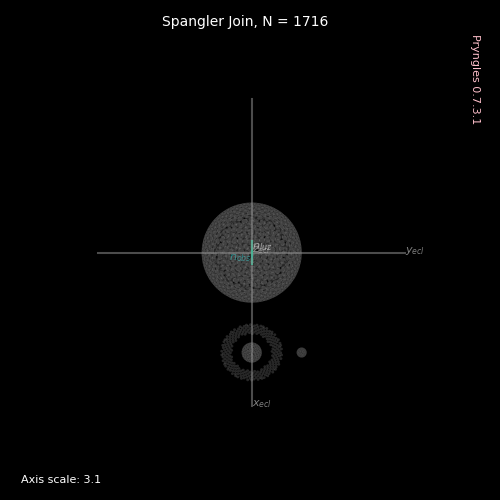

In [227]:
sg=Spangler()
sg.load_from("tmp/star-planet-ring.pkl")
sg.plot3d()

31 20


<IPython.core.display.Javascript object>


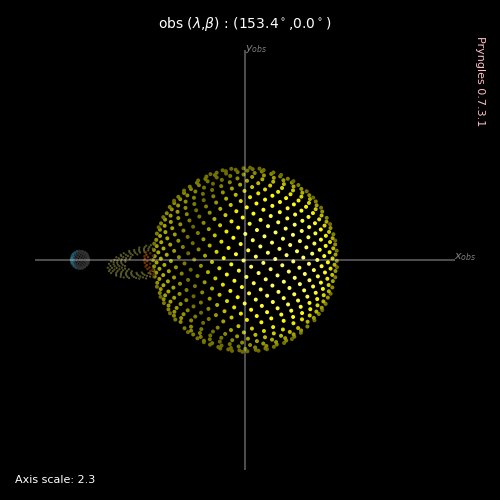

<IPython.core.display.Javascript object>


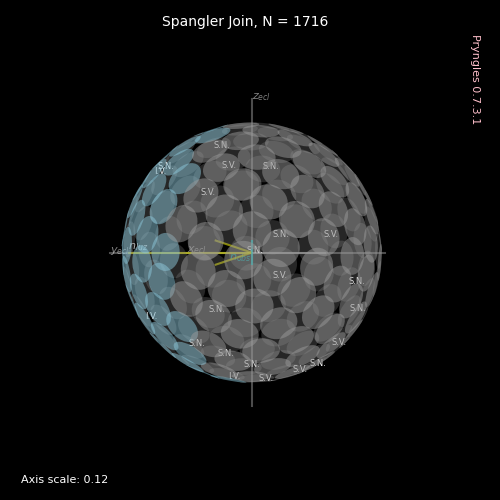

In [229]:
sg.reset_state()

#Set observer must be firs
#sg.set_observer(nvec=[1,1,0])
#sg.set_luz(nvec=[-1,0,0])
#sg.set_luz(nvec=[+1,+1,0])
sg.set_luz(nvec=[+1,0.5,0],center=[0,0,0])
sg.set_observer(nvec=[-1,0.5,0])
#sg.set_luz(nvec=[-1,0,0])

sg.update_simple_state()
sg.update_illumination_state()
sg.update_visibility_state()

#sg.plot3d(center_at="Ring")
print(sg.data[sg.data.sphash=="Moon"].illuminated.sum(),sg.data[sg.data.sphash=="Planet"].illuminated.sum())
sg.plot2d()
#sg.plot_obs(not_plot=["Star"],center_at="Ring")
#sg.plot3d()
sg.plot3d(only="Moon",debug=True)

<IPython.core.display.Javascript object>


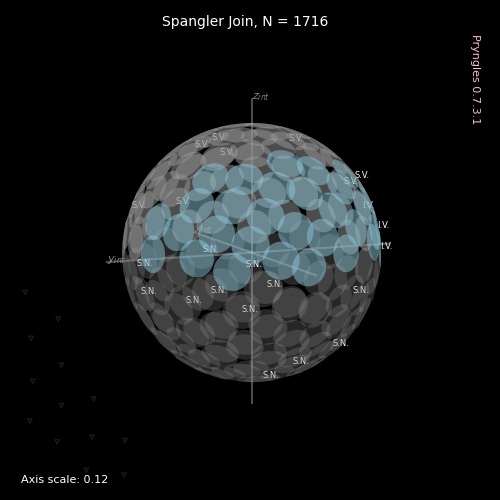

In [164]:
sg.plot3d(coords="int",center_at="Moon",debug=True,not_plot=["Star","Planet","Ring"])